In [1]:
import datetime
import gc
import json
import os
import pathlib
import shutil

import collections
import cytopus
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import scipy
import statsmodels.stats.multitest
import seaborn as sns
import Spectra as spectra

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [4]:
# Nick needs this because he's using Firefox which apparently noone uses anymore
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

# Analyse Spectra factors

The primary goal of this notebook is to test for difference in Spectra factors between SSc and controls

# 1. Load data

In [5]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [6]:
ds = sc.read_h5ad(DATA / '14a_spectra/14a_spectra.h5ad')

In [7]:
ds.obs.columns[:50]

Index(['Study', 'Sample', 'Sample ID', 'External Sample ID', 'Status',
       'Patient', 'Age', 'Sex', 'Smoking status', 'Race', 'BMI', 'Type',
       'Tissue location', 'Additional data', 'Chemistry', 'Fastq',
       'Genome build', 'Directory', 'Doublet threshold', 'batch', 'n_counts',
       'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes',
       'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels',
       'leiden_scVI', 'cell_type', 'cell_type_spectra', 'F_0_all_MYC_targets',
       'F_1_all_TGFb_response', 'F_2_all_TNF-via-NFkB_signaling',
       'F_3_all_actin-cytoskeleton_regulation', 'F_4_global',
       'F_5_all_amino-sugar-nucleotide-sugar_metabolism',
       'F_6_all_TNF-via-NFkB_signaling', 'F_7_all_ARG-PRO_metabolism',
       'F_8_all_ascorbate-uptake', 'F_9_M_macrophage_UP',
       'F_10_all_autophagy_regulation_positive', 'F_11_global',
       'F_12_all_autopha

# 2. Compute mean scores

Per sample per cell type. Keep only sample-cell-type pairs where we have more than 10 cells.

In [8]:
N_FACTORS = ds.obsm['SPECTRA_cell_scores'].shape[1]

In [9]:
factor_names = ds.obs.columns[-N_FACTORS:].tolist()
factor_df = ds.obs[
    ['External Sample ID', 'Status',  'cell_type', 'cell_type_spectra', 'Chemistry'] 
    + factor_names
].copy()

In [10]:
n_cells_per_group = factor_df.groupby(
    ['External Sample ID', 'Status', 'cell_type', 'cell_type_spectra', 'Chemistry'],
    observed=True
).size()

In [11]:
to_keep = n_cells_per_group.index[n_cells_per_group.gt(10)]

In [12]:
mean_factors = factor_df.groupby(
    ['External Sample ID', 'Status', 'cell_type', 'cell_type_spectra', 'Chemistry'], 
    observed=True
).mean()

In [13]:
mean_factors = mean_factors.loc[to_keep].reset_index()

# 3. Visualize on heatmap

In [14]:
col_colors = get_color_annotations(mean_factors, {
    'External Sample ID': 'tab20',
    'Status': ['red', 'skyblue'],
    'cell_type': sc.plotting.palettes.default_28,
    'cell_type_spectra': 'tab10',
    'Chemistry': ['gray', 'pink']
})

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


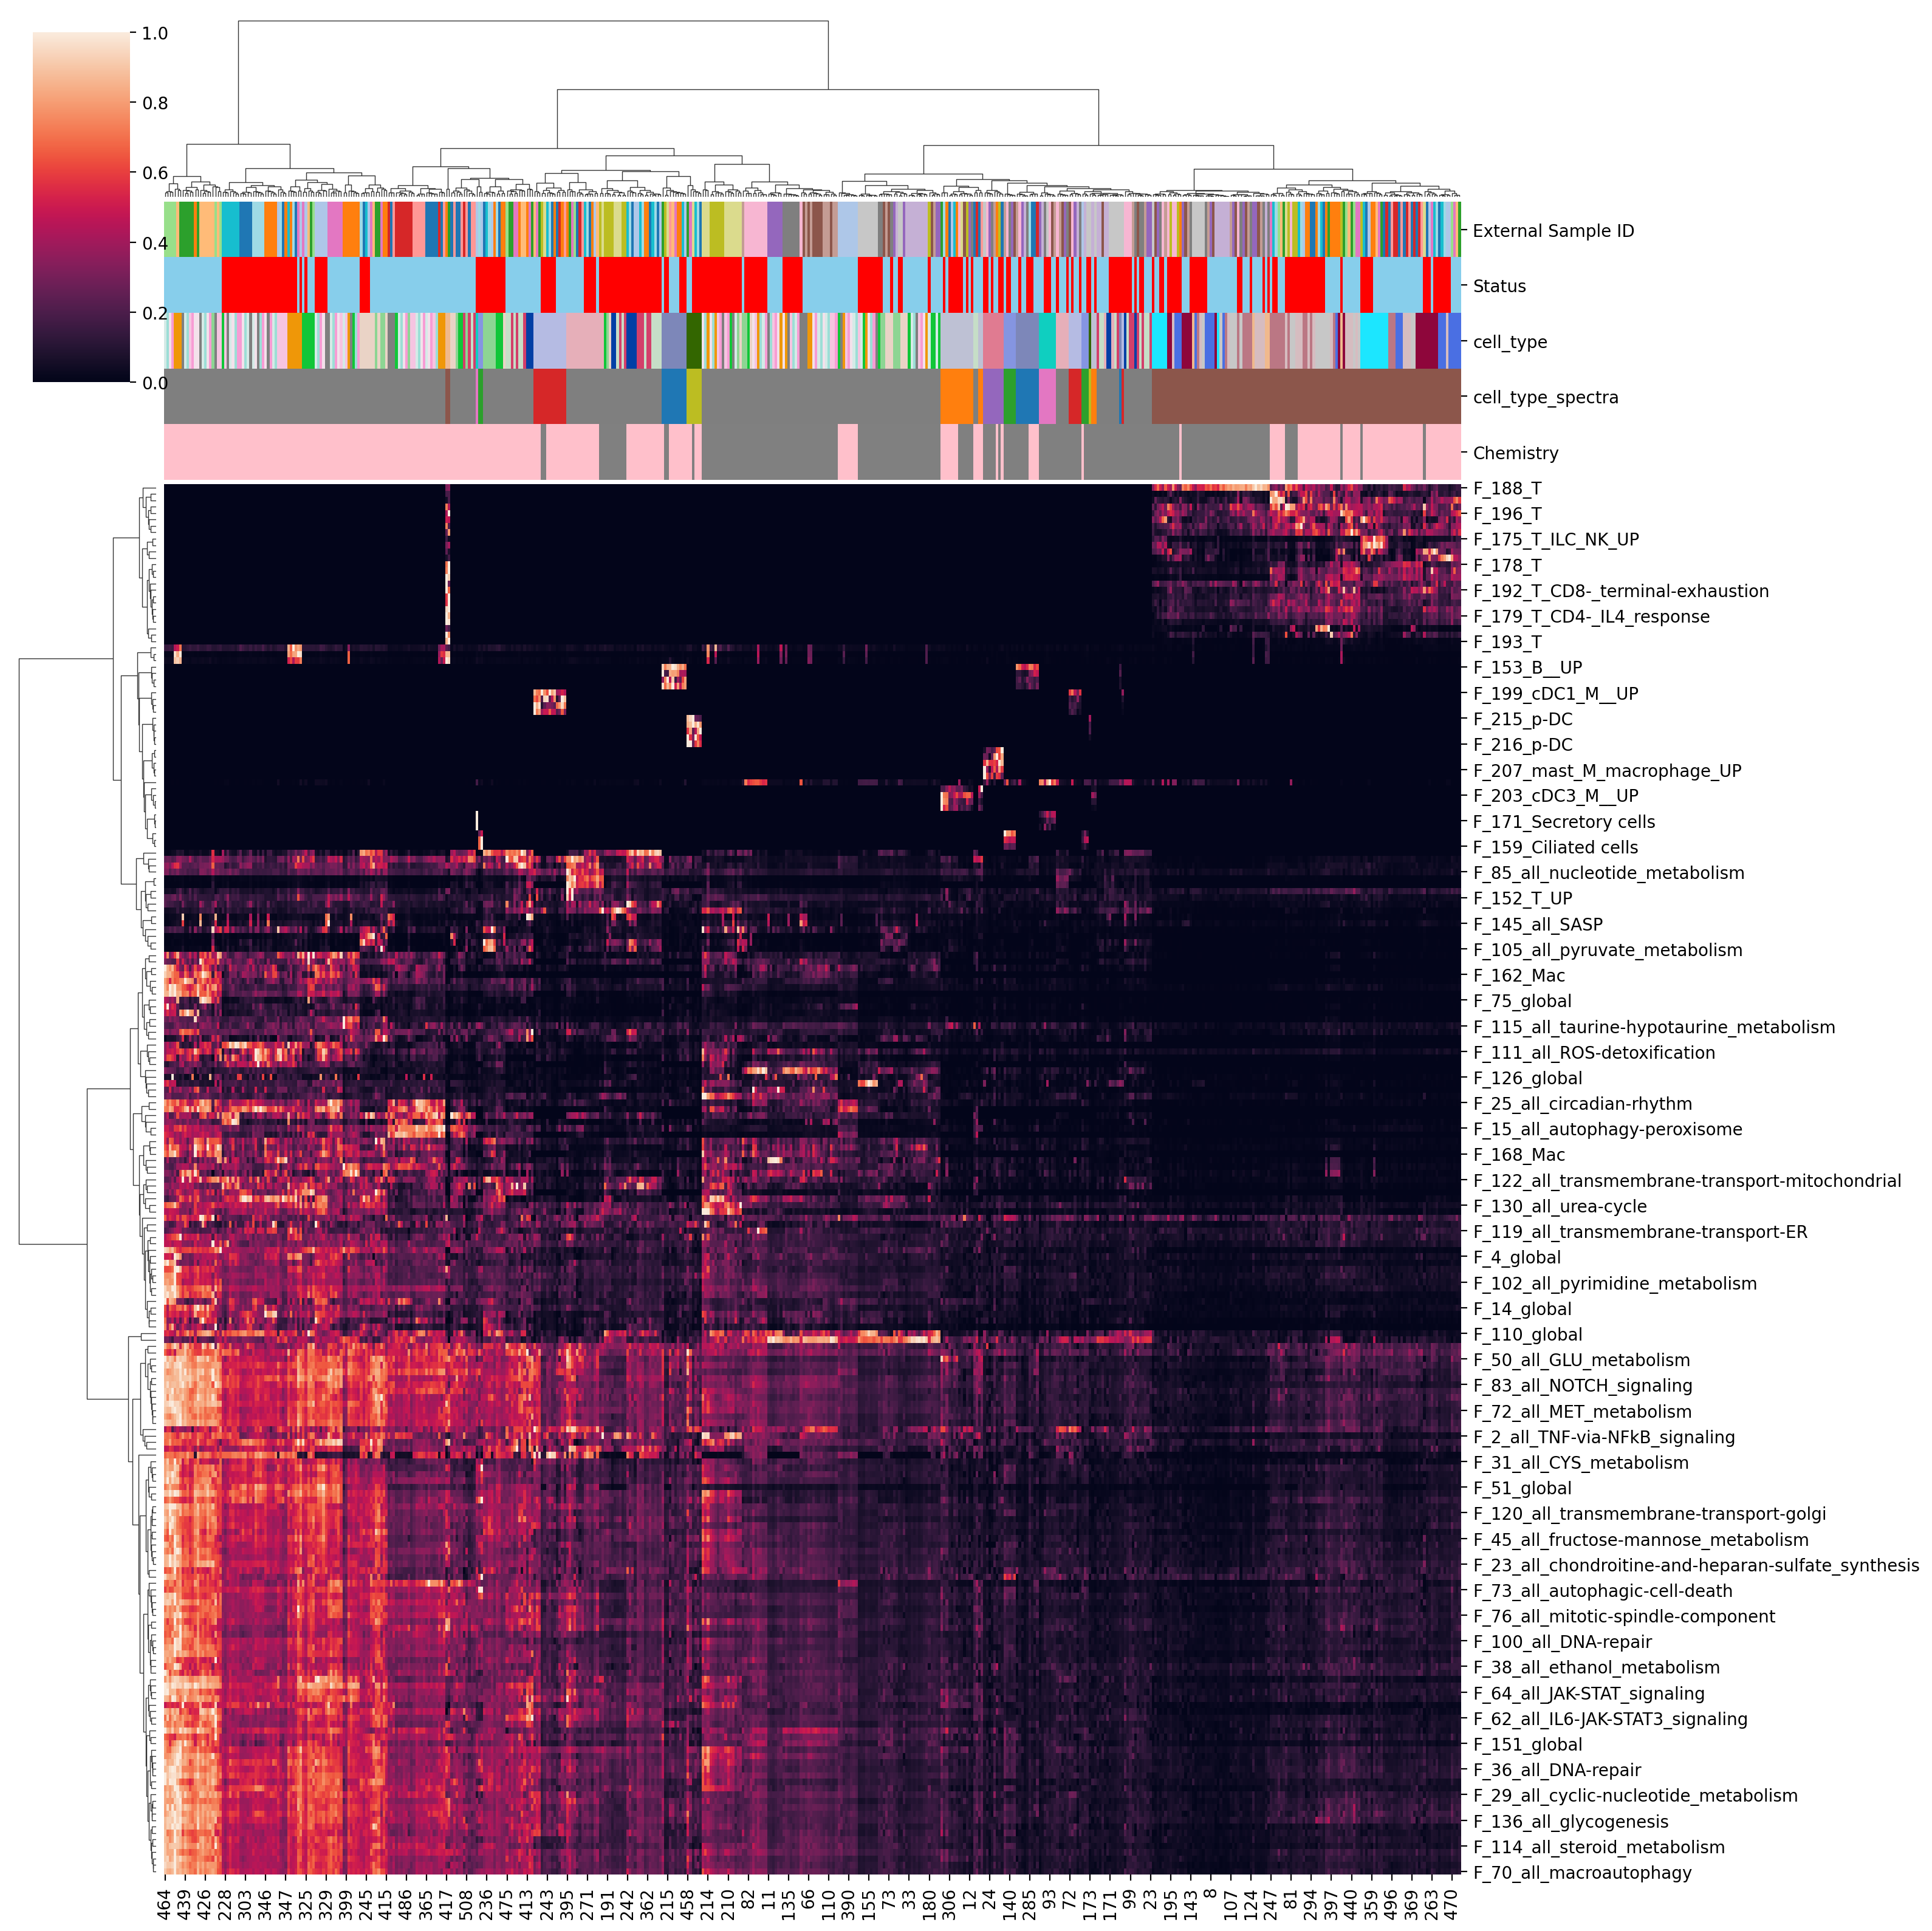

In [15]:
sns.clustermap(
    mean_factors.iloc[:, -N_FACTORS:].T,
    standard_scale=0,
    method='ward',
    dendrogram_ratio=0.1,
    figsize=(16, 16),
    col_colors=col_colors
)

Export to Morpheus

In [16]:
GENERATOR = 'Nick'

In [17]:
SPECTRA_PROG_DIR = pathlib.Path('14b_spectra')

In [18]:
os.makedirs(SPECTRA_PROG_DIR, exist_ok=True)

In [19]:
result_df_morpheus = mean_factors.iloc[:, -N_FACTORS:].T.copy()
result_df_morpheus.to_csv(SPECTRA_PROG_DIR / 'expr.tsv', sep='\t')

In [20]:
metadata_df_morpheus = mean_factors[
    ['External Sample ID', 'Status', 'cell_type', 'cell_type_spectra', 'Chemistry']
].rename(columns={
    'External Sample ID': 'Patient',
    'cell_type': 'Cell type'
}).reset_index(names='id')

metadata_df_morpheus.to_csv(SPECTRA_PROG_DIR / 'meta.tsv', sep='\t')

In [21]:
prog_meta = pd.DataFrame({
    'markers': np.apply_along_axis(lambda x: ', '.join(x), 1, ds.uns['SPECTRA_markers'][:, :5])
}, index=factor_names).reset_index(names='id')
prog_meta.to_csv(SPECTRA_PROG_DIR / 'prog_info.tsv', sep='\t')

In [22]:
HTML = """
<!DOCTYPE html>
<html>
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
    <meta http-equiv="content-type" content="text/html; charset=utf8"/>
    <title>SSc Spectra predobulk programs</title>
    <style type="text/css">
        html {
          margin: 0; padding: 0;
          font-size: 20px; font-family: Helvetica, Verdana, sans-serif;
        }
        body {margin: 0; padding: 10px 10px;}
        a {color: #1385cb}
        a:visited {color: #0e74bc}
        .header {margin-bottom: 10px;}
        .header h2, .header h3 {font-weight: normal; text-align: center; margin: 0 0 6px 0;}
        #morpheus-container {
            width: auto;
            height: auto;
            min-width: 1200px;
            min-height: 800px;
            visibility: hidden;
        }
      </style>
    <link rel="stylesheet" href="https://software.broadinstitute.org/morpheus/css/morpheus-latest.min.css">
    <script>if (typeof module === 'object') {
    window.module = module;
    module = undefined;

    }</script>

    <script type="text/javascript" src="https://software.broadinstitute.org/morpheus/js/morpheus-external-latest.min.js"></script>
    <script src="https://software.broadinstitute.org/morpheus/js/morpheus-latest.min.js"></script>
</head>
<body>
    <div class="header">
        <h3>SSc Spectra programs</h3>
        Generated by %s on %s.
        Sample-cell-type combination that had 10 or fewer cells were excluded.
        <a href="gene_weights"><b>Program gene plots</b></a>.
    </div>
    <div id="morpheus-container"></div>

    <script type="text/javascript">
        window.heatmap = new morpheus.HeatMap({
            el: document.querySelector('#morpheus-container'),
            name: "Pseudobulk of Spectra programs",
            dataset: "expr.tsv",
            columns: [
                {field: "Cell type", display: ["color"]},
                {field: "cell_type_spectra", display: ["color"]},
                {field: "Status", display: ["color"]},
                {field: "Chemistry", display: ["color"]},
                {field: "External Sample ID", display: ["color"]}
            ],
            rows: [
                {field: "id", display: ["color"]},
                {field: "markers", display: ["color"]}
            ],
            columnAnnotations: [{
                file: "meta.tsv",
                datasetField: "id",
                fileField: "id"
            }],
            rowAnnotations: [{
                file: "prog_info.tsv",
                datasetField: "id",
                fileField: "id"
            }],
            columnColorModel: {
                "Status": {
                    "control": "blue",
                    "SSc": "red"
                }
            },
            colorScheme: { // optional color scheme. default is relative
                scalingMode: 'relative',
                missingColor: '#f0f0f0',
                map: [{
                    value: 1,
                    color: '#ecaf7f'
                }, {
                    value: 0.5,
                    color: '#c44166'
                }, {
                    value: 0.25,
                    color: '#832f70'
                }, {
                    value: 0,
                    color: '#4a2162'
                }]
            },
            drawGrid: false,
            tools: [{ name: "Hierarchical Clustering", params: {cluster: "Rows and columns", background: false} }]
        });
        window.onload = function() {
            window.setTimeout(function() {
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                window.heatmap.heatmap.setDrawValuesFormat({pattern: '.5f'});
                document.getElementById('morpheus-container').style.visibility = 'visible';
            }, 200)
        }
    </script>
</body>
</html>
"""

In [23]:
html = HTML % (
    GENERATOR,
    datetime.datetime.now().strftime('%d %b %Y, %I:%M%p')
)

In [24]:
with open(SPECTRA_PROG_DIR / 'index.html', 'w') as out:
    out.write(html)

# 4. Compute pairwise stats

Here we compare distribution of each factor's mean scores between SSc and HC samples within each cell type. We use Wilcoxon rank-sum test since factors' scores are not normally distributed. We apply FDR correction within each cell type.

In [25]:
%%time
stats_results = []
for ct in mean_factors.cell_type.unique():
    for factor in mean_factors.columns[-N_FACTORS:]:
        vals1 = mean_factors[factor][
            mean_factors.cell_type.eq(ct) 
            & mean_factors.Status.eq('control')
        ]
        vals2 = mean_factors[factor][
            mean_factors.cell_type.eq(ct) 
            & mean_factors.Status.eq('SSc')
        ]
        if vals1.size == 0 or vals2.size == 0:
            continue
        # Remove empty factors not estimated for this cell type
        if vals1.max() == 0 or vals2.max() == 0:
            continue
        pval = scipy.stats.mannwhitneyu(vals1, vals2).pvalue
        stats_results.append([ct, factor, vals1.size, vals2.size, pval])
stats_results = pd.DataFrame(
    stats_results, 
    columns=["cell_type", "factor", "control_size", "ssc_size", "pval"]
)
#stats_results['padj'] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval)[1]

CPU times: user 9 s, sys: 1.96 ms, total: 9.01 s
Wall time: 9.06 s


Do FDR correction within each cell type independently

In [26]:
stats_results['padj'] = stats_results.groupby('cell_type').apply(
    lambda x: pd.Series(statsmodels.stats.multitest.fdrcorrection(x.pval)[1], index=x.index)
).reset_index(name='padj').set_index('level_1').padj

How many factors were significant before FDR?

In [27]:
stats_results.loc[stats_results.pval.lt(0.05)].shape

(254, 6)

How many factors were significant after FDR?

In [28]:
stats_results.loc[stats_results.padj.lt(0.05)].shape

(19, 6)

Top 20 results by $q$-value

In [29]:
stats_results.sort_values('padj').head(20)

cell_type                                factor  control_size  \
424               TRAM-2                  F_82_M_macrophage_UP            13   
502               TRAM-2               F_167_Mac_M_monocyte_UP            13   
455               TRAM-2                 F_113_M_macrophage_UP            13   
437               TRAM-2        F_95_all_riboflavin_metabolism            13   
766               TRAM-3                  F_82_M_macrophage_UP            13   
2192  MoAM-4 profibrotic                           F_11_global            11   
930               TRAM-4                  F_82_M_macrophage_UP            13   
1272       MoAM-3 mature                  F_82_M_macrophage_UP            13   
1614              TRAM-1                  F_82_M_macrophage_UP            13   
1627              TRAM-1        F_95_all_riboflavin_metabolism            13   
1637              TRAM-1         F_105_all_pyruvate_metabolism            13   
1692              TRAM-1               F_167_Mac_M_monocyte_UP            13   
1651              TRAM-1  F_119_all_transmembrane-transport-ER            13   
1778         TRAM-5 MT1G                  F_82_M_macrophage_UP            13   
1955    TRAM-6 activated        F_95_all_riboflavin_metabolism            13   
1942    TRAM-6 activated                  F_82_M_macrophage_UP            13   
1791         TRAM-5 MT1G        F_95_all_riboflavin_metabolism            13   
1809         TRAM-5 MT1G                 F_113_M_macrophage_UP            13   
1850         TRAM-5 MT1G                             F_161_Mac            13   
2263  MoAM-4 profibrotic                  F_82_M_macrophage_UP            11   

      ssc_size      pval      padj  
424         10  0.000063  0.010383  
502         10  0.000137  0.011209  
455         10  0.000362  0.014861  
437         10  0.000362  0.014861  
766         10  0.000106  0.017409  
2192        10  0.000124  0.020361  
930         10  0.000175  0.028765  
1272        10  0.000175  0.028765  
1614        10  0.000286  0.029725  
1627        10  0.000458  0.029725  
1637        10  0.000725  0.029725  
1692        10  0.000578  0.029725  
1651        10  0.001130  0.037073  
1778        10  0.000458  0.037585  
1955        10  0.000458  0.037585  
1942        10  0.000458  0.037585  
1791        10  0.000286  0.037585  
1809        10  0.000907  0.046342  
1850        10  0.001130  0.046342  
2263        10  0.000637  0.052250

Save all results into csv

In [30]:
stats_results.sort_values('padj').to_csv('14b_spectra_ssc_vs_hc.csv')

# 5. Dump top 30 genes for all programs

In [31]:
HTML = """
<!DOCTYPE html>
<html>
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
    <meta http-equiv="content-type" content="text/html; charset=utf8"/>
    <title>SSc Spectra program genes</title>
    <style type="text/css">
        html {
          margin: 0; padding: 0;
          font-size: 20px; font-family: Helvetica, Verdana, sans-serif;
        }
        body {margin: 0; padding: 10px 10px; height: 100vh;}
        a {color: #1385cb}
        a:visited {color: #0e74bc}
        .header {margin-bottom: 10px;}
        .header h2, .header h3 {font-weight: normal; text-align: center; margin: 0 0 6px 0;}
        #container {
            display: flex;
            width: 100%%;
            height: 90vh;
        }
        #index {
            padding-right: 10px;
            border-right: 1px solid gray;
            overflow-y: auto;
            font-size: 13px;
        }
        #index a {
            display: block;
            padding: 2px 0;
        }
        #index a:hover {
            background-color: #e0eaf0;
        }
        #plots {
            overflow-y: auto;
        }
        #plots img {
            max-width: 100%%;
        }
      </style>
</head>
<body>
    <div class="header">
        <h3>SSc Spectra program genes</h3>
        Generated by %s on %s.
    </div>
    <div id="container">
        <div id="index">
            %s
        </div>
        <div id="plots">
            %s
        </div>
    </div>
</body>
</html>
"""

In [32]:
INDEX_CHUNK = '<a href="#%(name)s">%(name)s</a>'
PLOT_CHUNK = '<div id="%(name)s"><img src="%(name)s.png"/></div>'

In [33]:
GENE_PLOTS_PATH = SPECTRA_PROG_DIR / 'gene_weights'
os.makedirs(GENE_PLOTS_PATH, exist_ok=True)
indices = ''
plots = ''
for i, factor in enumerate(ds.obs.columns[-N_FACTORS:]):
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    gene_weights = pd.Series(ds.uns['SPECTRA_factors'][i], index=ds.var_names)
    gene_weights_top = gene_weights.sort_values(ascending=False).head(30)
    ax.bar(range(len(gene_weights_top)), gene_weights_top, color='#aaa')
    ax.axhline(gene_weights_top.min(), c='black', ls='--', lw=1)
    ax.set_xticks(
        range(len(gene_weights_top)), 
        labels=gene_weights_top.index,
        fontstyle='italic',
        rotation=45,
        ha='right'
    )
    ax.set_ylabel('Gene weight', size=16)
    ax.set_title(factor, size=16)
    ax2 = fig.add_axes((0.7, 0.6, 0.28, 0.30))
    ax2.hist(gene_weights, bins=25, log=True, color='#aaa')
    ax2.spines[['top', 'right']].set_visible(False)
    ax2.axvline(gene_weights_top.min(), c='black', ls='--', lw=1)
    ax2.set_xlabel('Gene weight', size=10)
    ax2.set_ylabel('Number of genes (log)', size=10)
    ax2.annotate(
        'top 30 genes', 
        (gene_weights_top.min(), 1),
        xytext=(10, -30),
        xycoords=('data', 'axes fraction'),
        textcoords='offset pixels',
        size=10
    )
    fig.savefig(GENE_PLOTS_PATH / f'{factor}.png')
    plt.close()
    indices += INDEX_CHUNK % dict(name=factor)
    plots += PLOT_CHUNK % dict(name=factor)

In [34]:
html = HTML % (
    GENERATOR,
    datetime.datetime.now().strftime('%d %b %Y, %I:%M%p'),
    indices,
    plots
)

In [35]:
with open(GENE_PLOTS_PATH / 'index.html', 'w') as out:
    out.write(html)

# 6. Correlation of program scores with PFT and HRCT

In [14]:
sample_info = pd.read_csv('../00all-samples.csv')

In [15]:
clinical_info = pd.read_csv('../00clinical-v2.csv')

In [16]:
# Moving BronchSSc_03_SR1025 PFT measurements from baseline to followup
clinical_info.loc[
    clinical_info.study_code.eq("BronchSSc_03_SR1025"), 
    "study_code"
] = "BronchSSc_03_SR1025_followup"

In [17]:
mean_factors_w_clinical = mean_factors.merge(
    sample_info[['External Sample ID', 'Sample', 'Sex']],
    on='External Sample ID',
    how='left'
).merge(
    clinical_info,
    left_on='Sample',
    right_on='study_code',
    how='left'
)

In [18]:
def spectra_clinical_corr(
        data, 
        factor_names, 
        clinical_feature, 
        fdr=True,
        min_number_of_obs=5
):
    stats = pd.DataFrame(
        index=factor_names,
        columns=data.cell_type.unique(),
    )
    pvals = stats.copy()
    for cell_type in data.cell_type.unique():
        for factor in factor_names:
            idx = data.cell_type.eq(cell_type)
            f_data = data[factor][idx]
            clinical_data = data[clinical_feature][idx]
            idx = clinical_data.notna()
            f_data = f_data[idx]
            clinical_data = clinical_data[idx]
            # factor is not estimated for the cell type
            # ALSO require at least X dots for correlation
            if f_data.max() == 0 or f_data.size < min_number_of_obs:
                stats.loc[factor, cell_type] = np.nan
                pvals.loc[factor, cell_type] = np.nan
                continue
            res = scipy.stats.spearmanr(f_data, clinical_data)
            stats.loc[factor, cell_type] = res.statistic
            pvals.loc[factor, cell_type] = res.pvalue
    # subset on non-empty rows and columns
    col_idx = pvals.notna().sum(axis=0).gt(0)
    row_idx = pvals.notna().sum(axis=1).gt(0)
    stats = stats.loc[row_idx, col_idx]
    pvals = pvals.loc[row_idx, col_idx]
    if fdr:
        padj = statsmodels.stats.multitest.fdrcorrection(pvals.values.flatten())[1]
        padj = padj.reshape(pvals.shape)
        pvals = pd.DataFrame(padj, index=pvals.index, columns=pvals.columns)
    return stats, pvals

In [19]:
def plot_spectra_clinical_corr(stats, pvals, feature_name):
    stars = np.empty_like(pvals, dtype='U3')
    stars[pvals.lt(0.05)] = '*'
    stars[pvals.lt(0.01)] = '**'
    stars[pvals.lt(0.001)] = '***'
    
    trans = mpl.transforms.Affine2D().translate(0, -1)
    
    cg = sns.clustermap(
        stats.fillna(0),
        mask=stats.isna(),
        cmap='vlag',
        annot=stars,
        fmt='',
        method='ward',
        figsize=(18, 20),
        dendrogram_ratio=0.1,
        cbar_pos=(0.01, 0.85, 0.02, 0.1),
        cbar_kws=dict(
            label=f'$Spearman~\\rho(avg(factor), {feature_name})$'
        ),
        yticklabels=stats.index,
        annot_kws=dict(
            size=10,
            va='center_baseline',
        )
    )
    for text in cg.ax_heatmap.texts:
        text.set_transform(text.get_transform() + trans)
        
    cg.ax_heatmap.set_facecolor('#333')
    cg.ax_heatmap.tick_params(axis='y', labelsize=6)
    cg.ax_col_dendrogram.set_title(f'Correlation with {feature_name}, FDR corrected', size=16)
    return cg

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


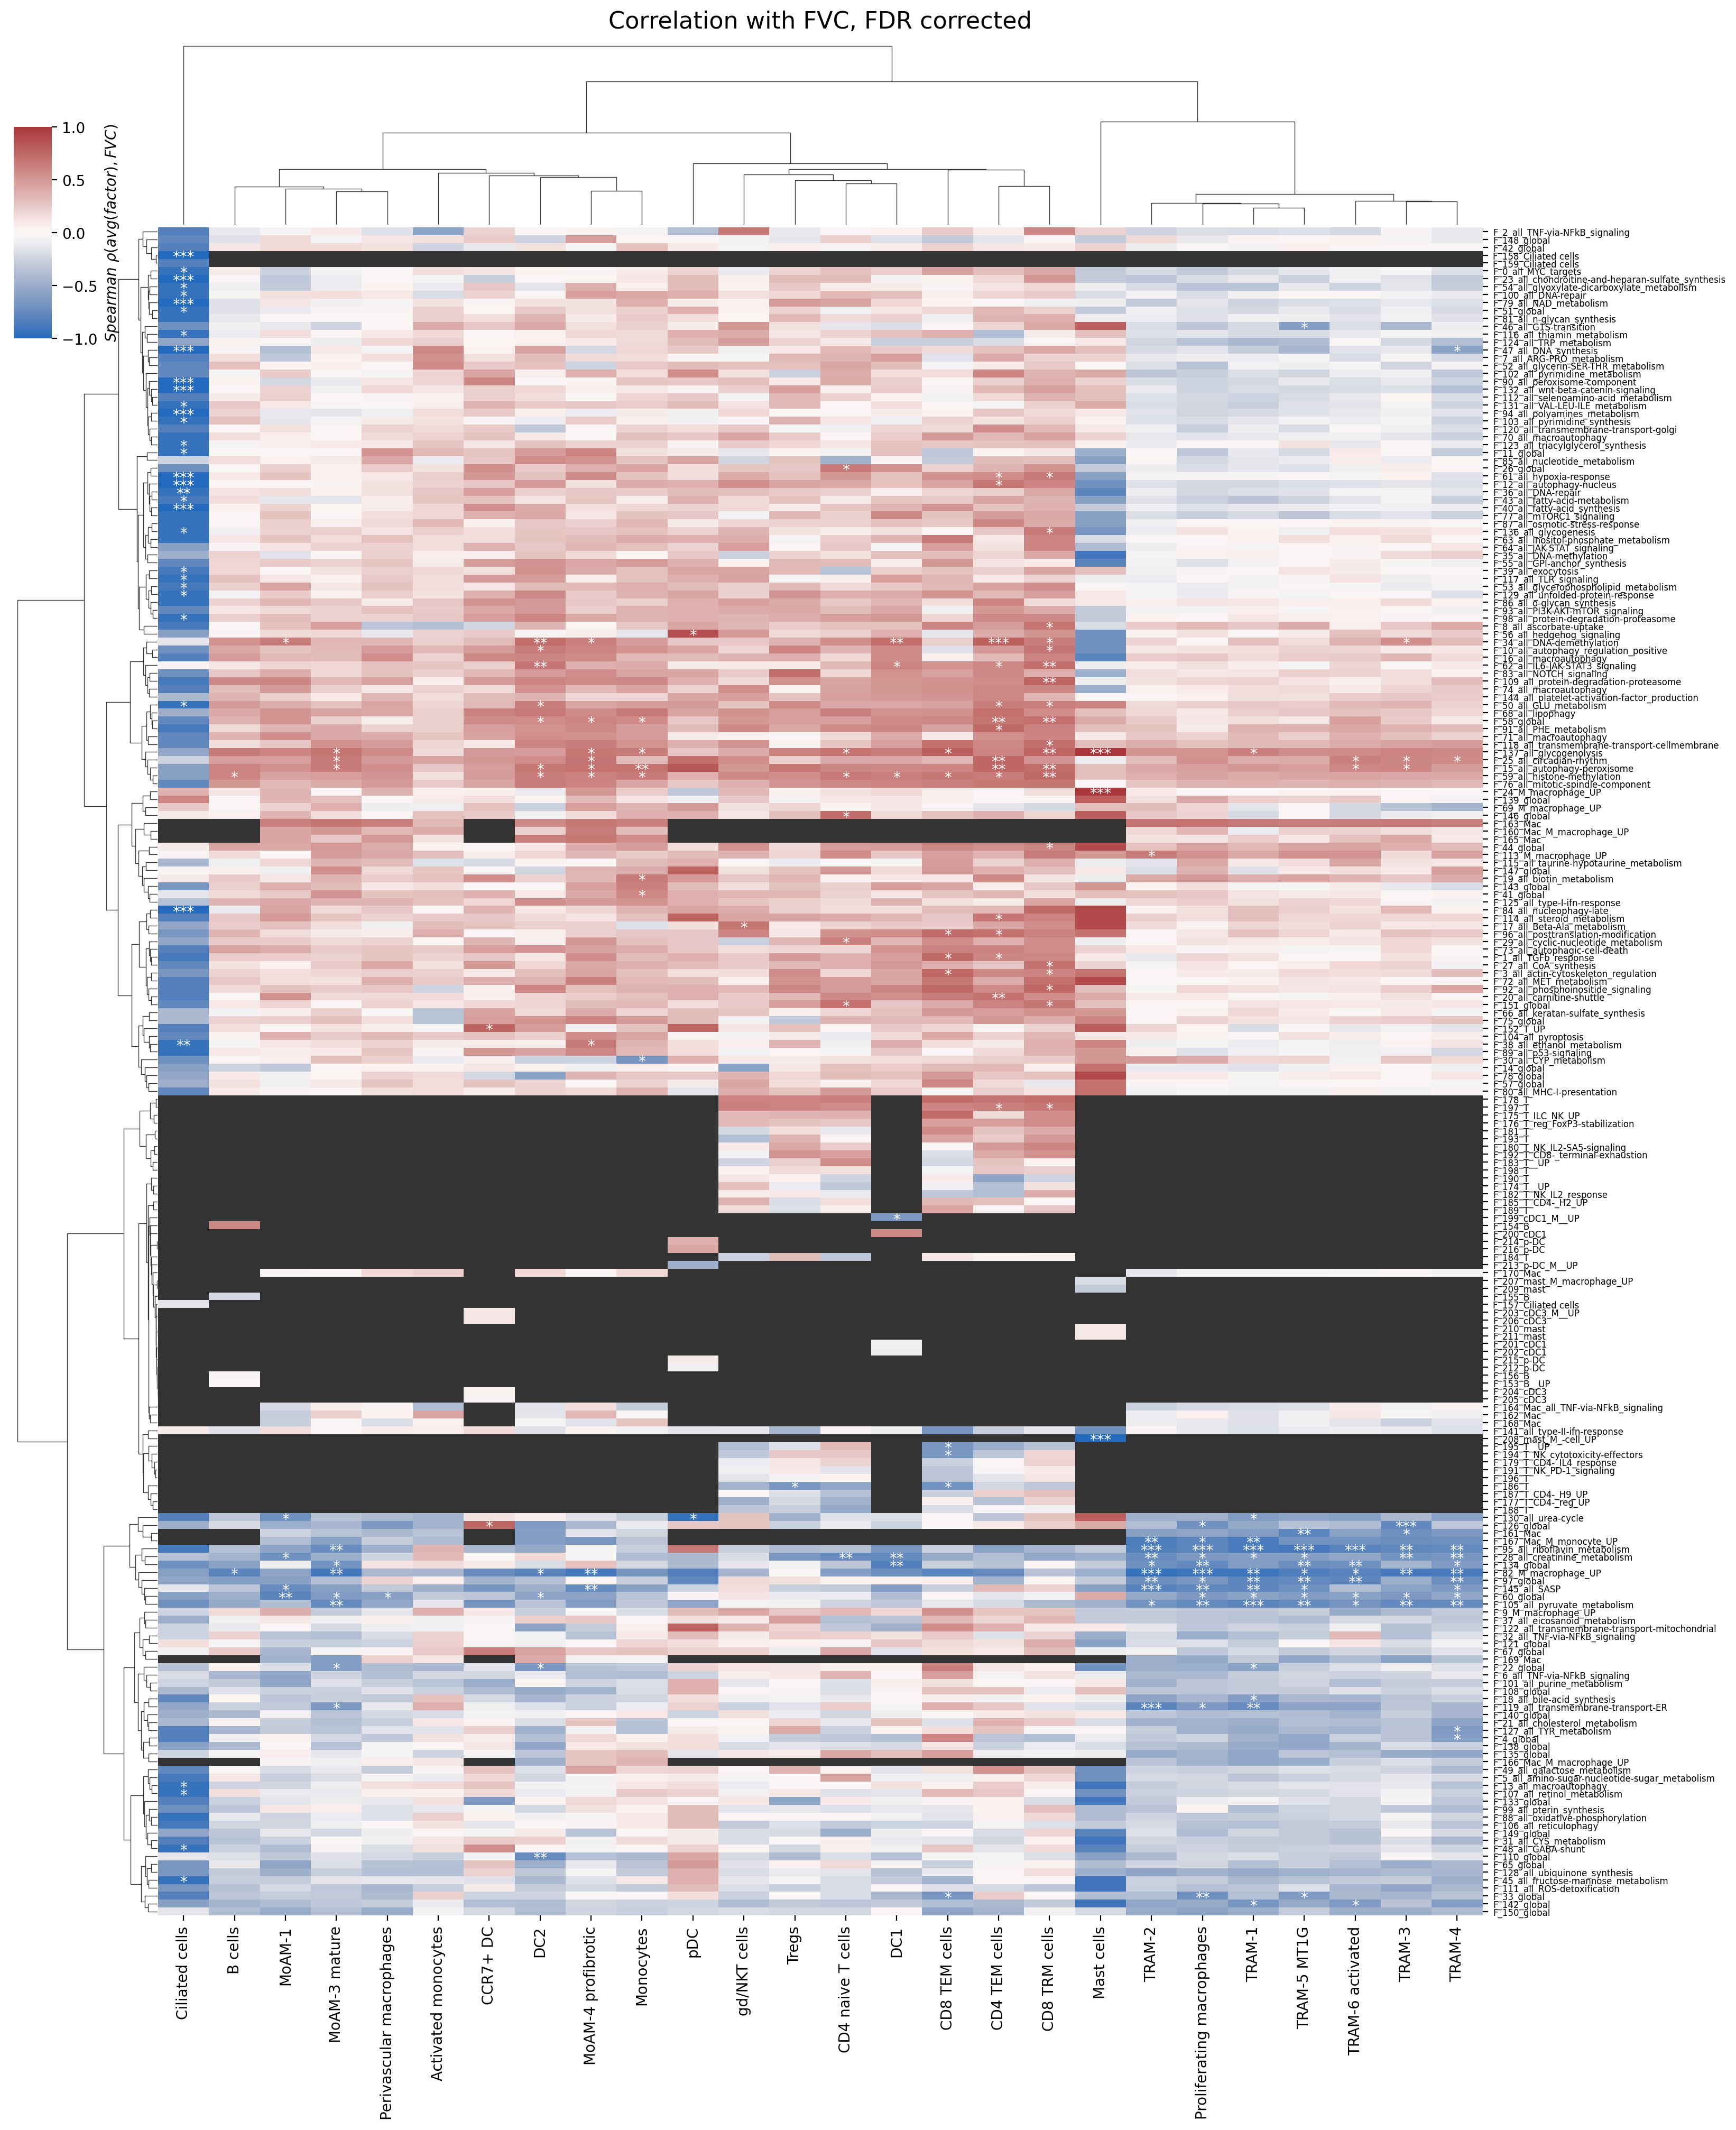

In [20]:
stats, pvals = spectra_clinical_corr(
    mean_factors_w_clinical,
    factor_names,
    clinical_feature='fvc_pred'
)
cg = plot_spectra_clinical_corr(stats, pvals, 'FVC')
cg.ax_col_dendrogram.figure.savefig('14b_factors_vs_fvc.pdf', dpi=300)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


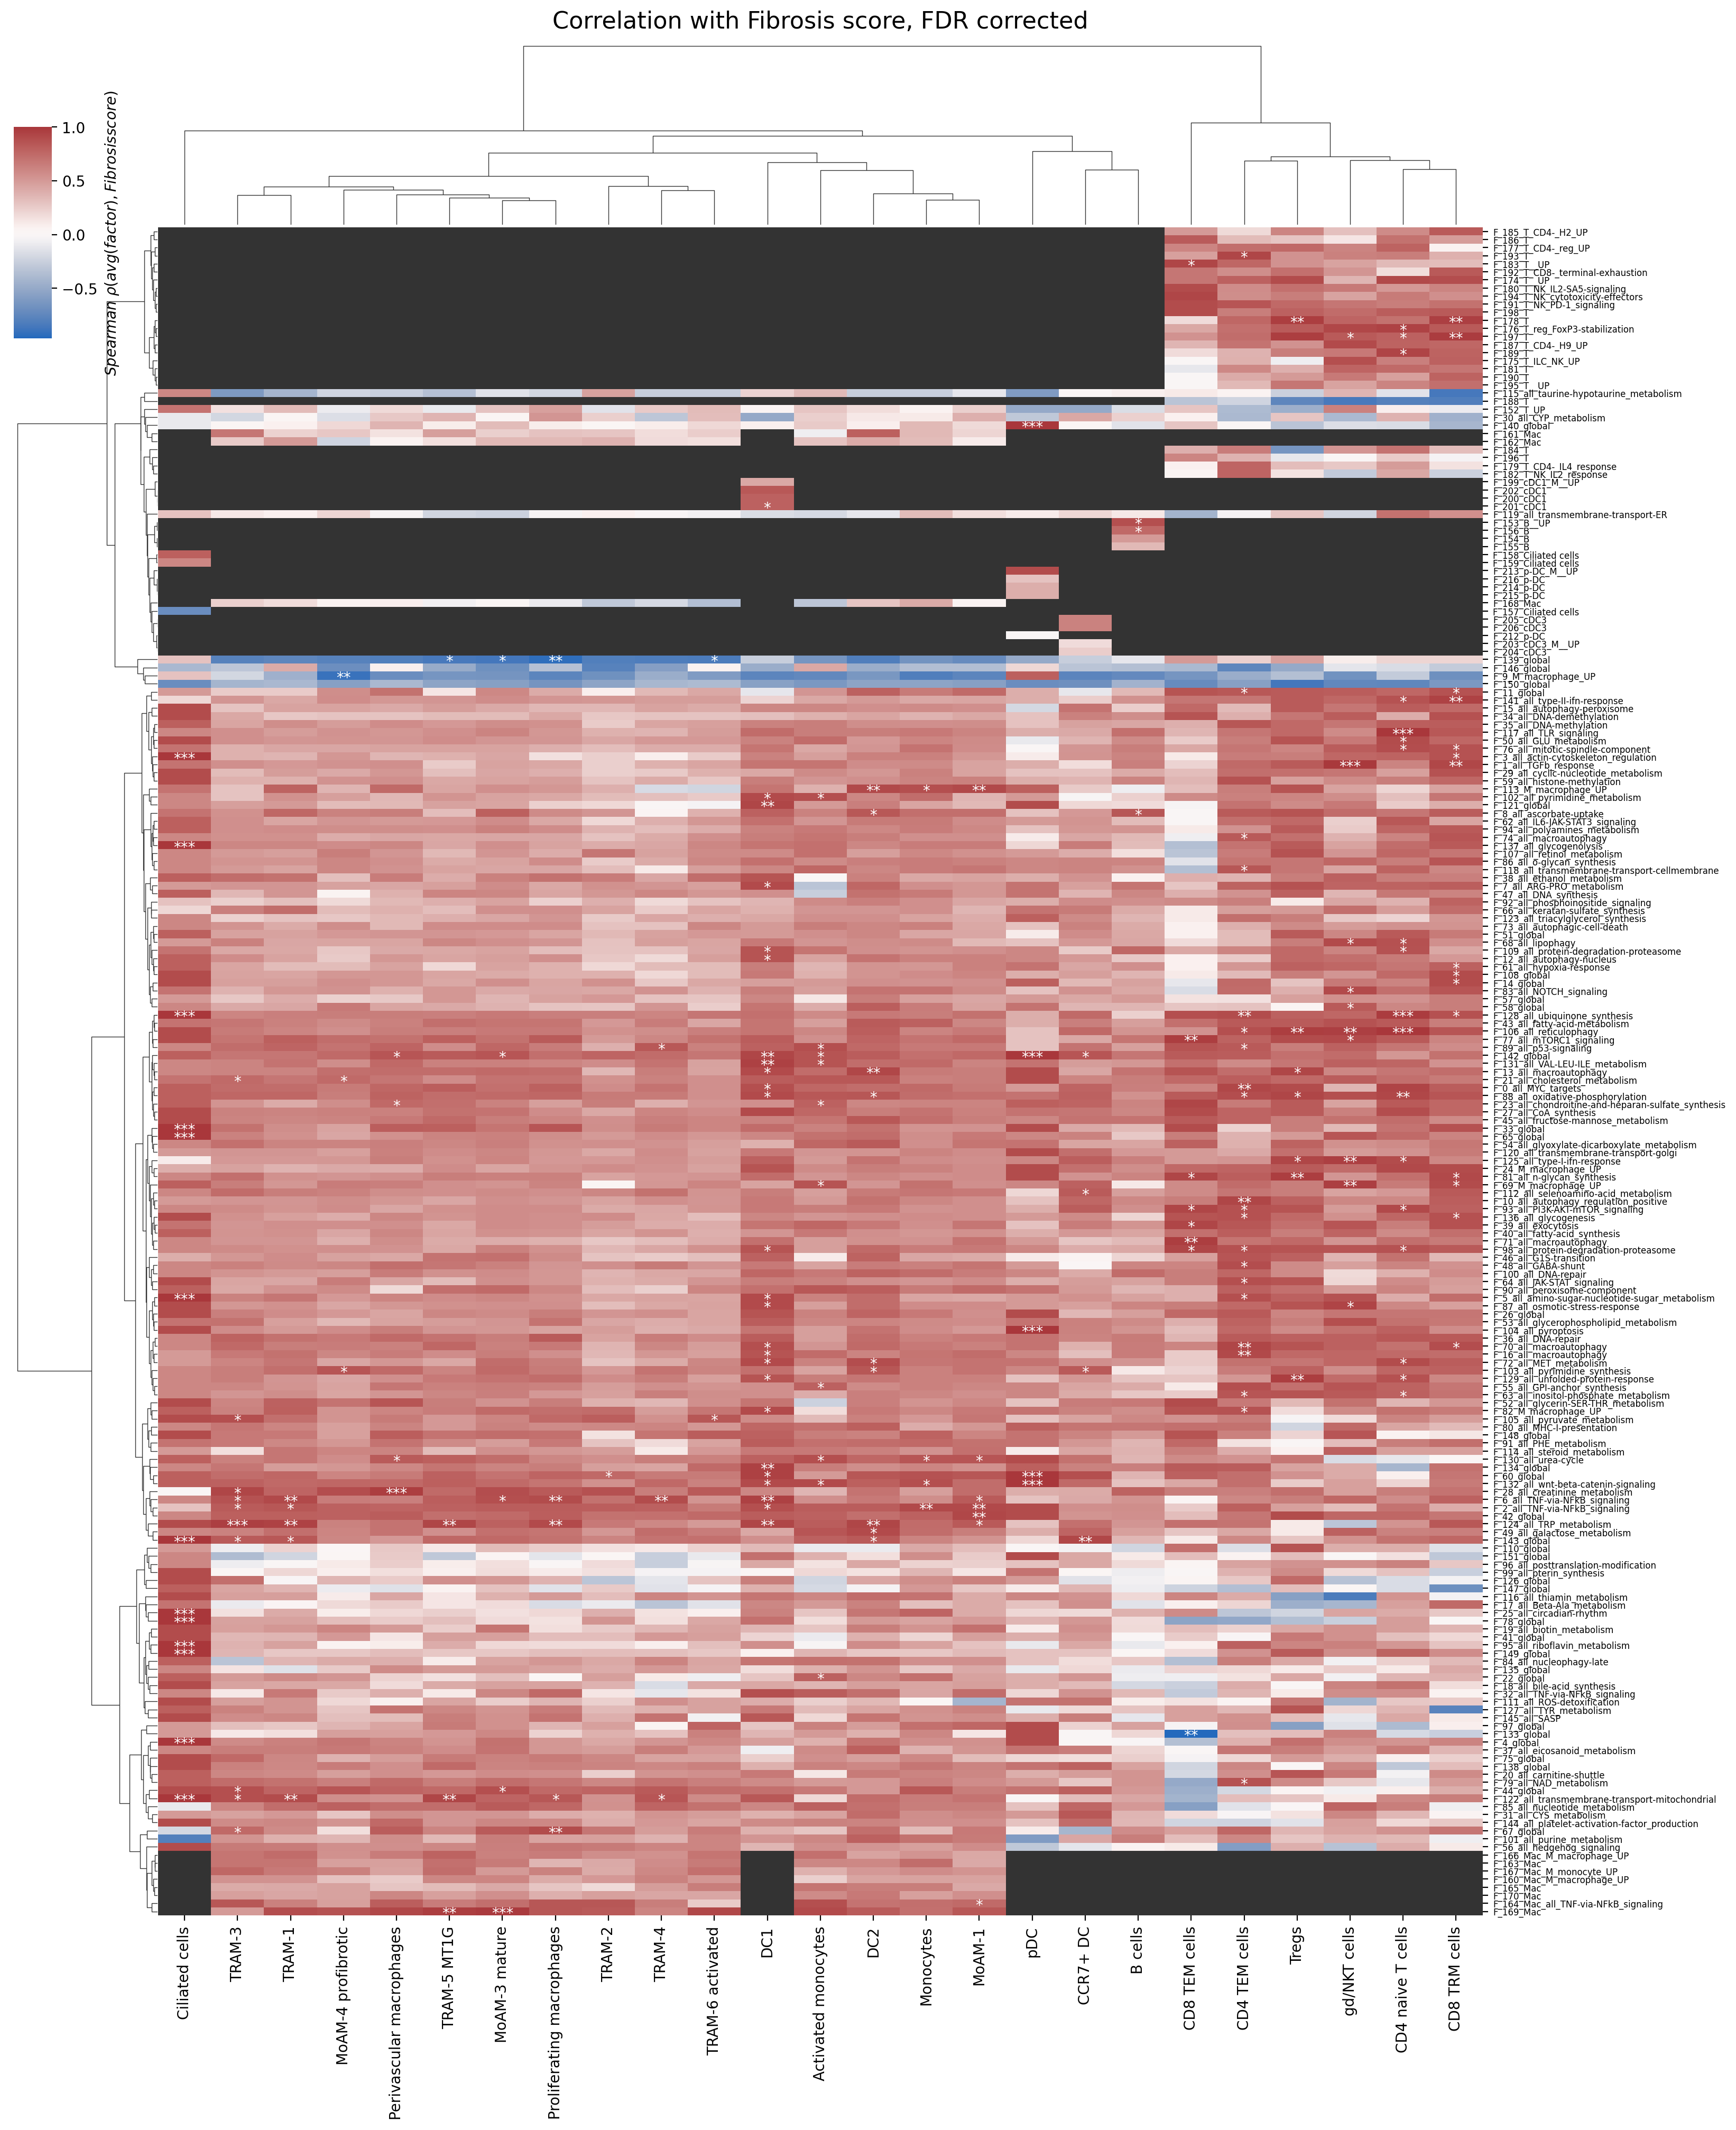

In [21]:
stats, pvals = spectra_clinical_corr(
    mean_factors_w_clinical,
    factor_names,
    clinical_feature='k_score_fib'
)
cg = plot_spectra_clinical_corr(stats, pvals, 'Fibrosis score')
cg.ax_col_dendrogram.figure.savefig('14b_factors_vs_fib_score.pdf', dpi=300)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


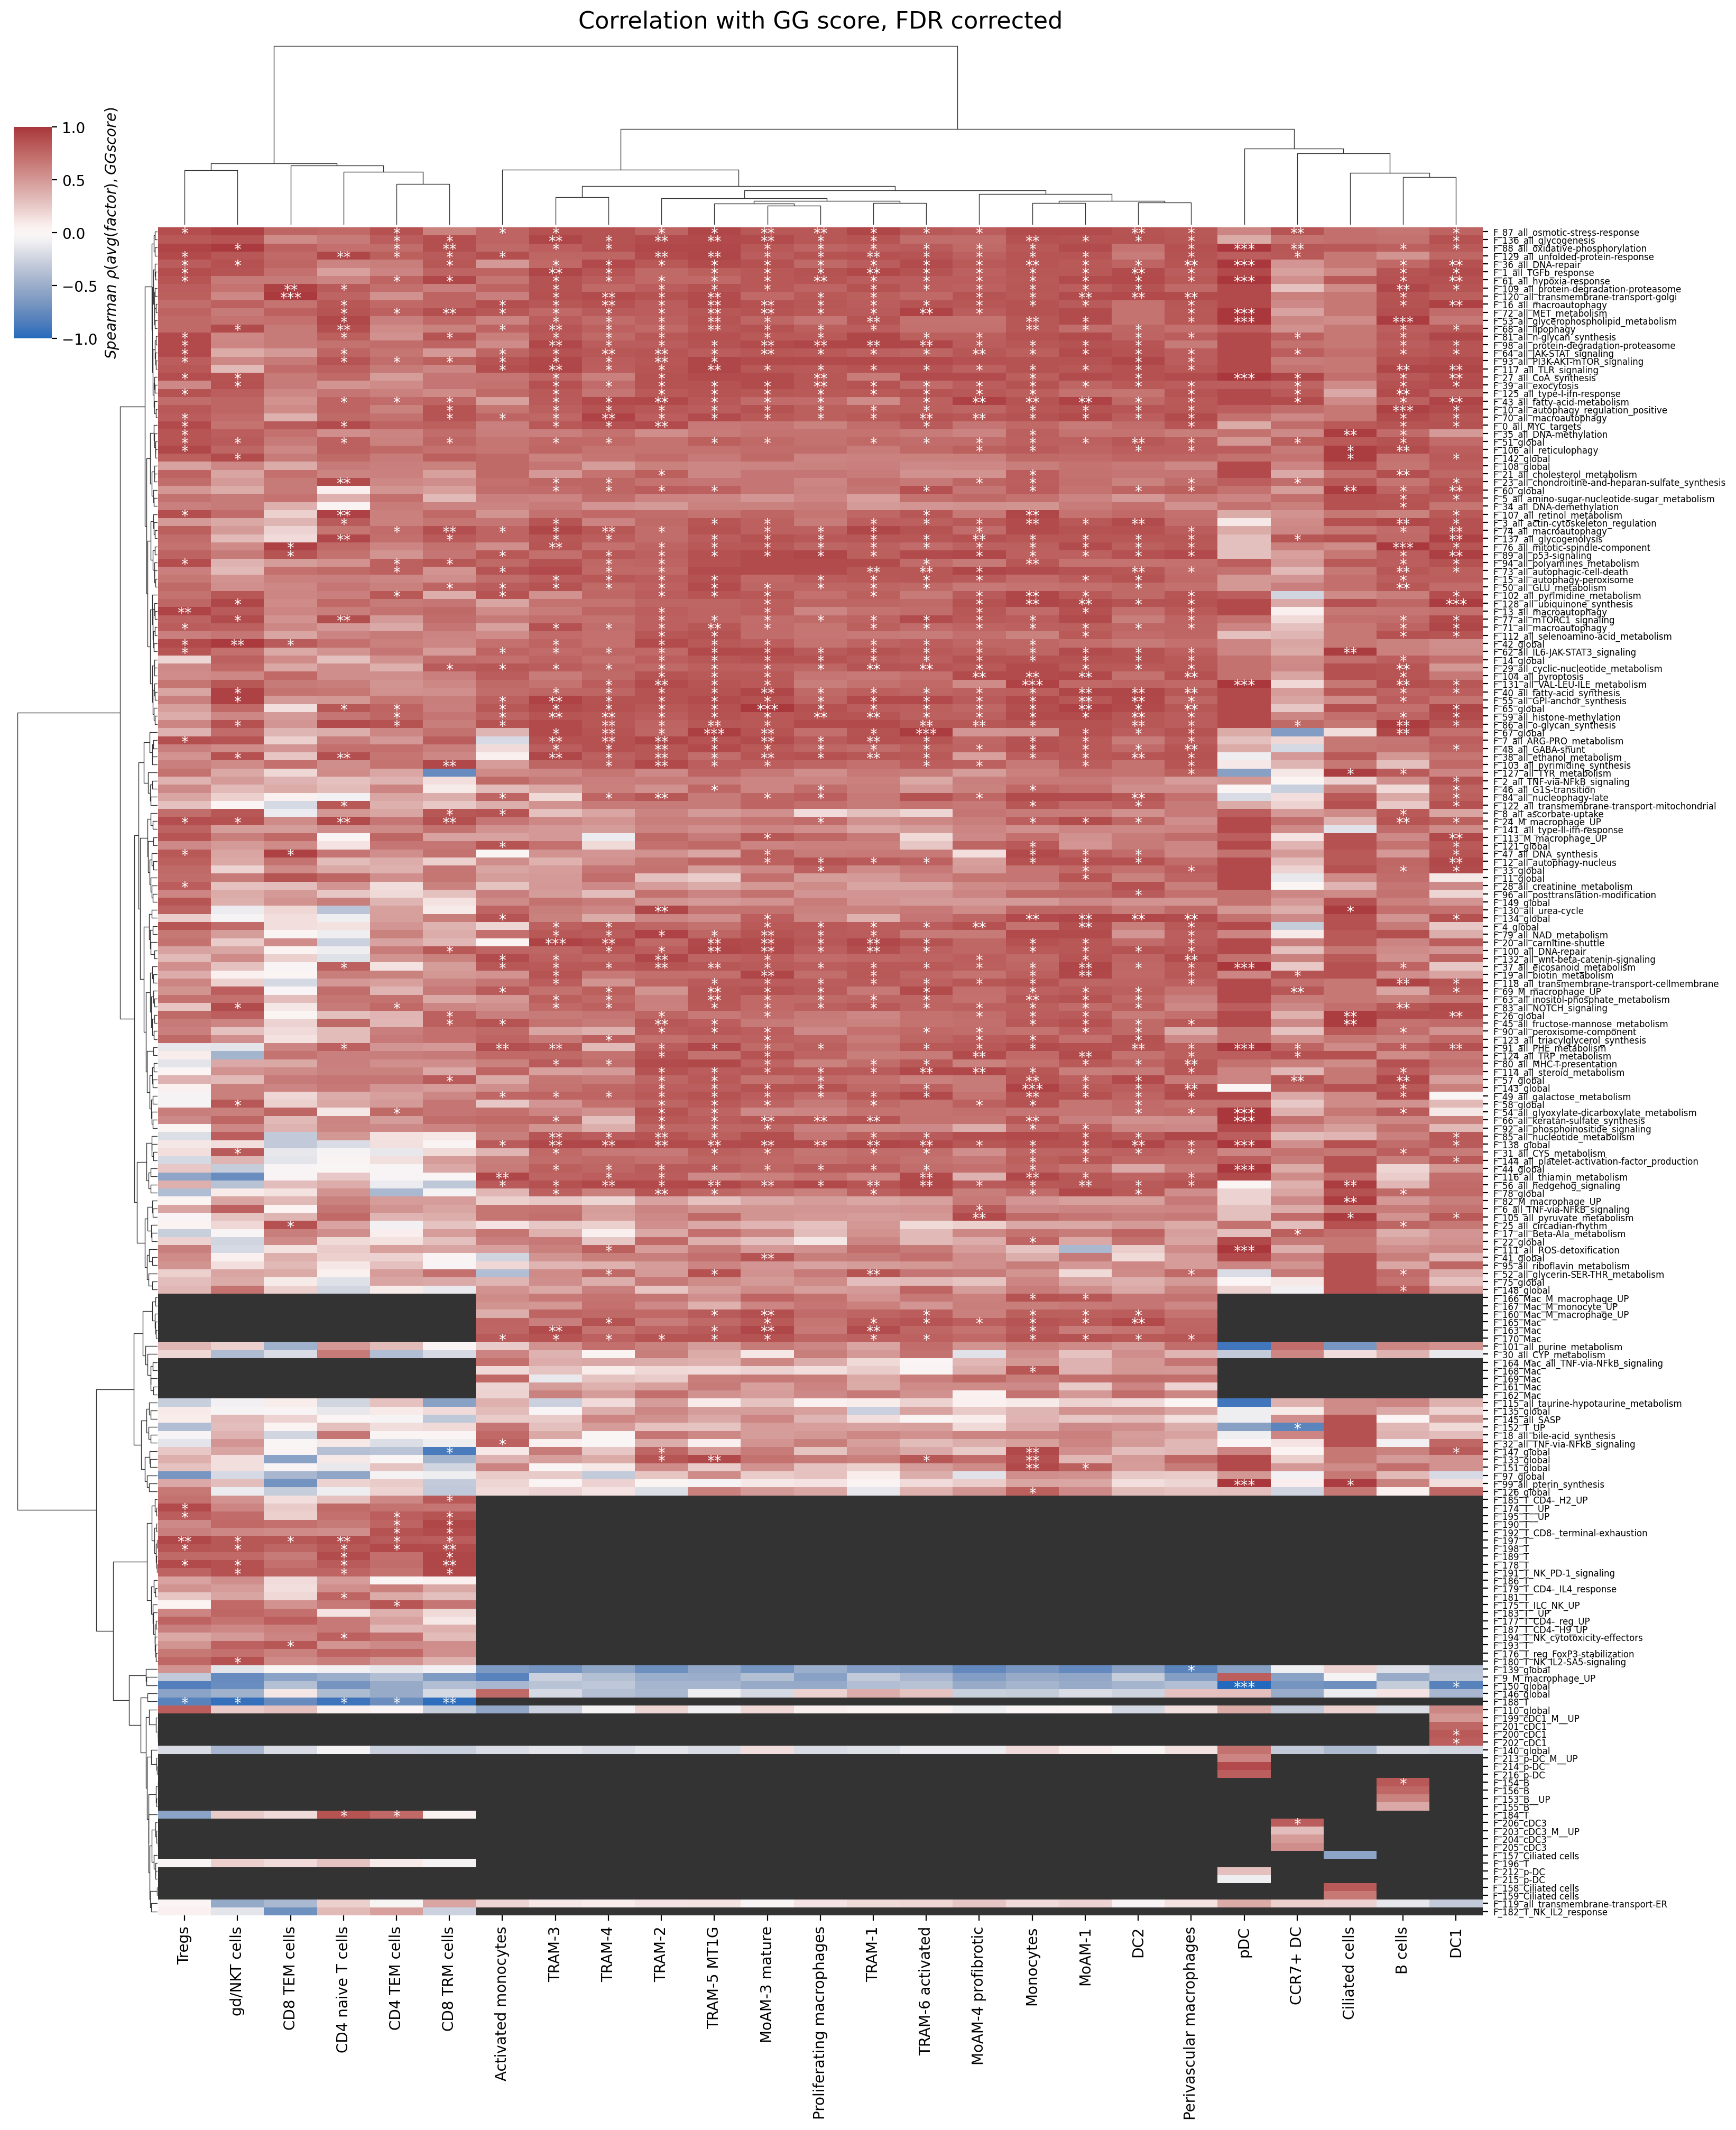

In [22]:
stats, pvals = spectra_clinical_corr(
    mean_factors_w_clinical,
    factor_names,
    clinical_feature='k_score_gg'
)
cg = plot_spectra_clinical_corr(stats, pvals, 'GG score')
cg.ax_col_dendrogram.figure.savefig('14b_factors_vs_gg_score.pdf', dpi=300)

### 6.1 Bias

Last two heatmaps clearly show that we have bias in the data.

Let's see one of the correlation plots from the Fibrotic heatmap

In [23]:
stats, pvals = spectra_clinical_corr(
    mean_factors_w_clinical,
    factor_names,
    clinical_feature='k_score_fib'
)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


In [24]:
pvals['TRAM-1'].sort_values()

F_124_all_TRP_metabolism                            0.00111
F_6_all_TNF-via-NFkB_signaling                     0.005505
F_122_all_transmembrane-transport-mitochondrial    0.009745
F_2_all_TNF-via-NFkB_signaling                     0.032296
F_143_global                                       0.038154
                                                     ...   
F_212_p-DC                                              NaN
F_213_p-DC_M__UP                                        NaN
F_214_p-DC                                              NaN
F_215_p-DC                                              NaN
F_216_p-DC                                              NaN
Name: TRAM-1, Length: 209, dtype: object

<Axes: xlabel='F_124_all_TRP_metabolism', ylabel='k_score_fib'>

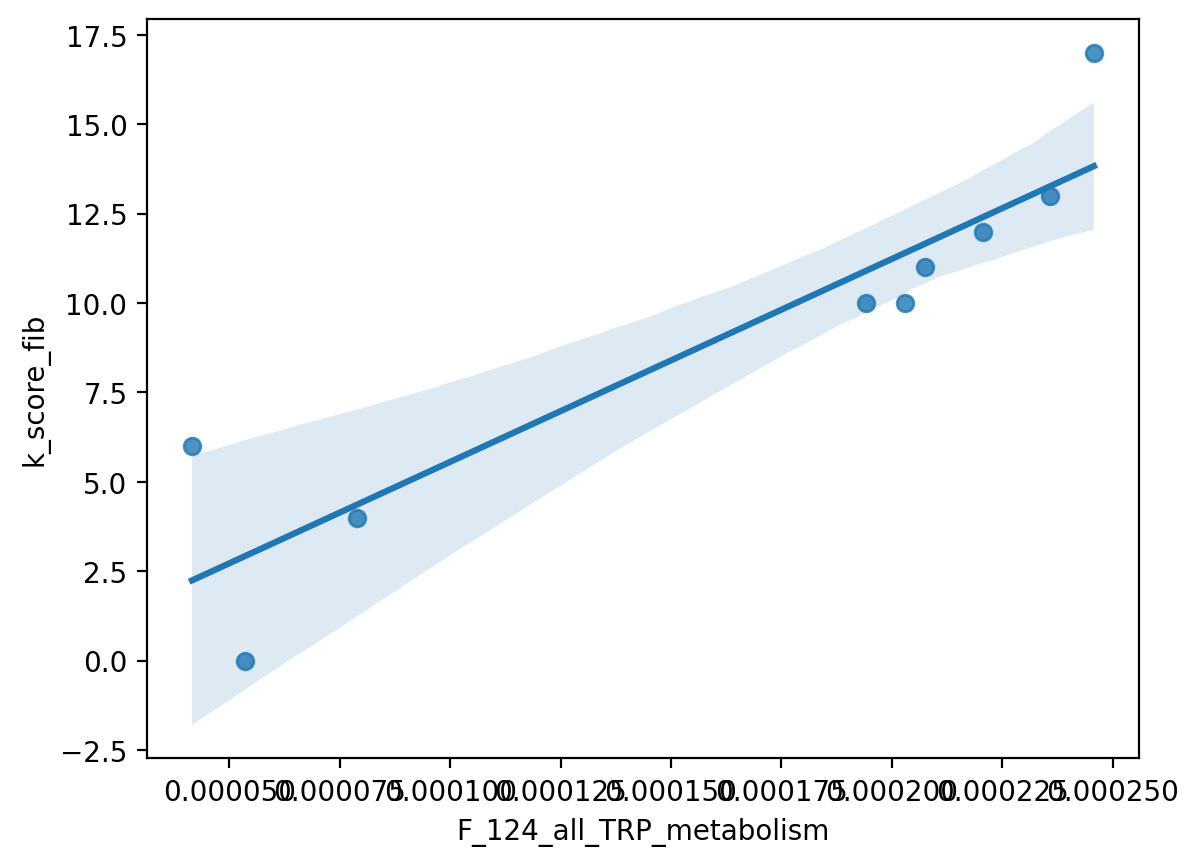

In [25]:
sns.regplot(
    data=mean_factors_w_clinical.loc[mean_factors_w_clinical.cell_type.eq('TRAM-1')],
    x='F_124_all_TRP_metabolism',
    y='k_score_fib'
)

After looking at the top genes for the factors that show up as negatively correlated with Kazerooni scores, I had an idea that this is sex-related.

Let's look at Kazerooni scores by sex, but also by chemistry.

<Axes: xlabel='Sex', ylabel='k_score_fib'>

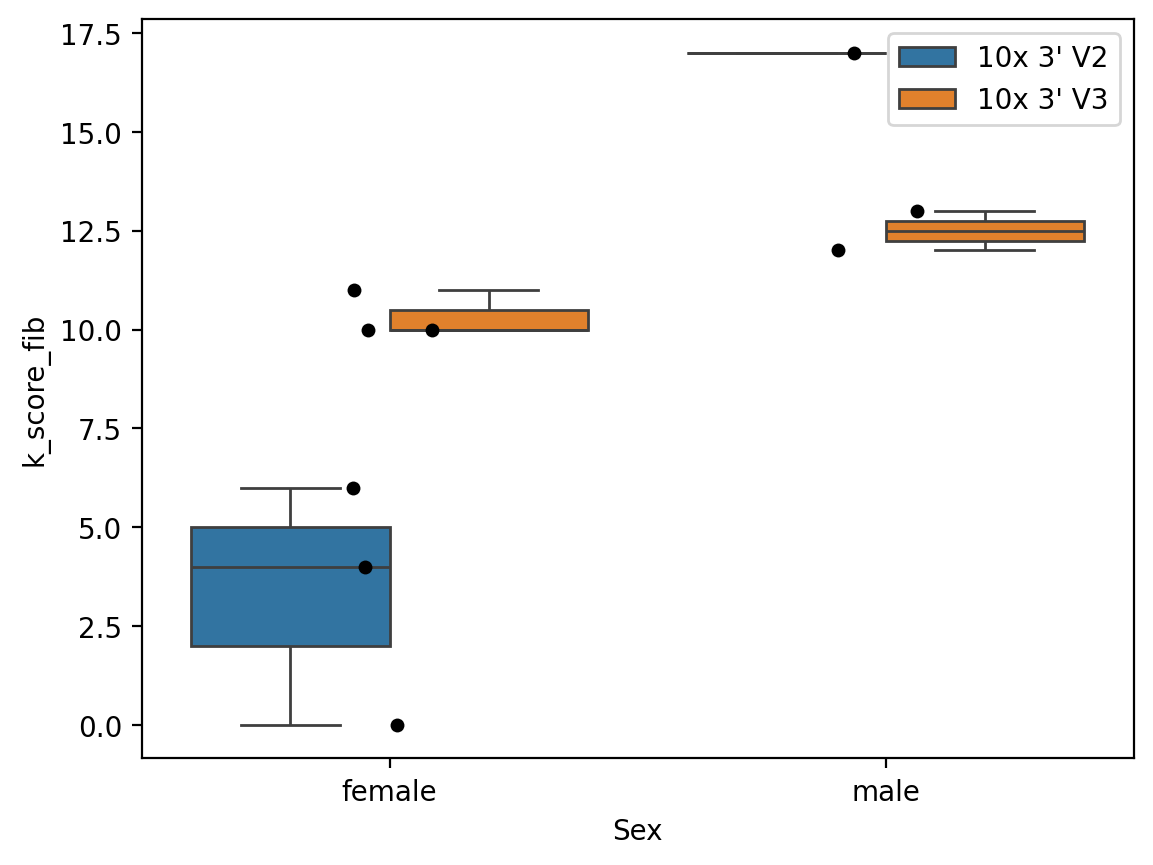

In [26]:
sns.boxplot(
    data=clinical_info.merge(sample_info, left_on='study_code', right_on='Sample'),
    x='Sex',
    y='k_score_fib',
    hue='Chemistry'
)
sns.stripplot(
    data=clinical_info.merge(sample_info, left_on='study_code', right_on='Sample'),
    x='Sex',
    y='k_score_fib',
    color='k'
)

<Axes: xlabel='Sex', ylabel='k_score_gg'>

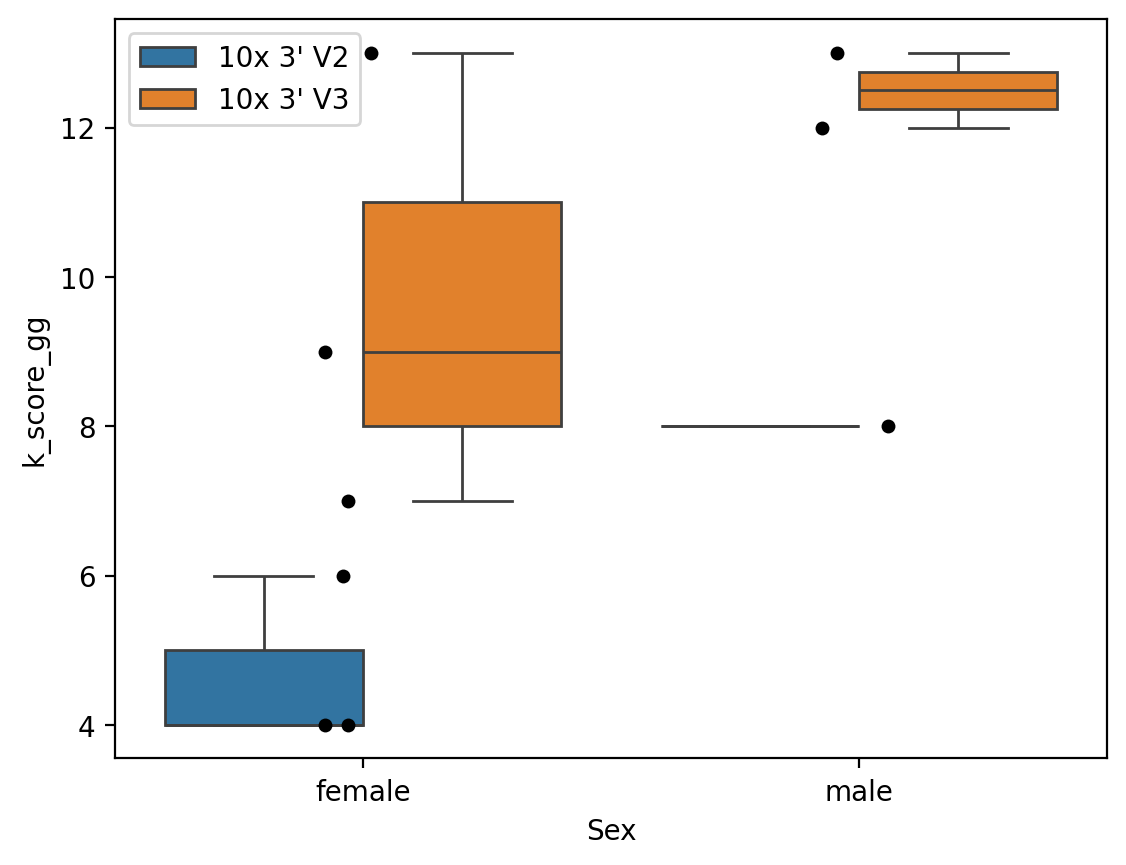

In [27]:
sns.boxplot(
    data=clinical_info.merge(sample_info, left_on='study_code', right_on='Sample'),
    x='Sex',
    y='k_score_gg',
    hue='Chemistry'
)
sns.stripplot(
    data=clinical_info.merge(sample_info, left_on='study_code', right_on='Sample'),
    x='Sex',
    y='k_score_gg',
    color='k'
)

<Axes: xlabel='Sex', ylabel='fvc_pred'>

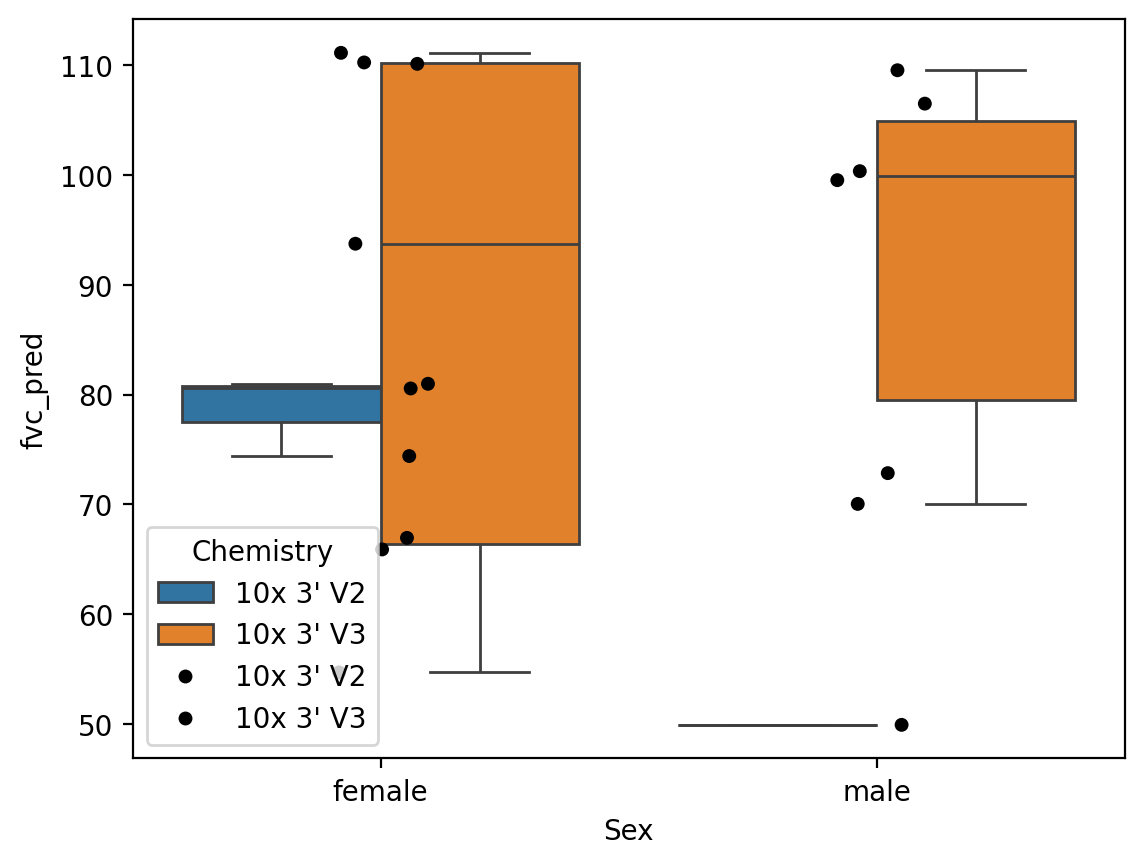

In [28]:
sns.boxplot(
    data=clinical_info.merge(sample_info, left_on='study_code', right_on='Sample'),
    x='Sex',
    y='fvc_pred',
    hue='Chemistry'
)
sns.stripplot(
    data=clinical_info.merge(sample_info, left_on='study_code', right_on='Sample'),
    x='Sex',
    y='fvc_pred',
    hue='Chemistry',
    palette=['k', 'k']
)

Yep, it seems like chemistry is majorly affecting Spectra scores, and also 3 patients on V2 had significantly lower Kazerooni scores then the rest, which would be driving the majority of correlations.

What it means:
- correlations with Kazerooni scores should be done on V3 samples only
- correlations with FVC seem to be alright

Because of this, let's export FVC data as a table

In [29]:
stats, pvals = spectra_clinical_corr(
    mean_factors_w_clinical,
    factor_names,
    clinical_feature='fvc_pred'
)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


In [30]:
stats.melt(
    var_name='cell_type',
    value_name='Spearman rho',
    ignore_index=False
).reset_index(names='factor').merge(
    pvals.melt(
        var_name='cell_type',
        value_name='padj',
        ignore_index=False
    ).reset_index(names='factor'),
    on=['factor', 'cell_type']
).to_csv('14b_factors_vs_fvc_corr.csv')

And to morpheus

In [32]:
GENERATOR = 'Nick'

In [33]:
SPECTRA_CORR_DIR = pathlib.Path('14b_spectra_fvc_corr')

In [34]:
os.makedirs(SPECTRA_CORR_DIR, exist_ok=True)

In [36]:
stats.to_csv(SPECTRA_CORR_DIR / 'stats.tsv', sep='\t')
pvals.to_csv(SPECTRA_CORR_DIR / 'pvals.tsv', sep='\t')

In [37]:
prog_meta = pd.DataFrame({
    'markers': np.apply_along_axis(lambda x: ', '.join(x), 1, ds.uns['SPECTRA_markers'][:, :5])
}, index=factor_names).reset_index(names='id')
prog_meta.to_csv(SPECTRA_CORR_DIR / 'prog_info.tsv', sep='\t')

In [91]:
HTML = """
<!DOCTYPE html>
<html>
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
    <meta http-equiv="content-type" content="text/html; charset=utf8"/>
    <title>SSc Spectra predobulk programs</title>
    <style type="text/css">
        html {
          margin: 0; padding: 0;
          font-size: 20px; font-family: Helvetica, Verdana, sans-serif;
        }
        body {margin: 0; padding: 10px 10px;}
        a {color: #1385cb}
        a:visited {color: #0e74bc}
        .header {margin-bottom: 10px;}
        .header h2, .header h3 {font-weight: normal; text-align: center; margin: 0 0 6px 0;}
        #morpheus-container {
            width: auto;
            height: auto;
            min-width: 1200px;
            min-height: 800px;
            visibility: hidden;
        }
      </style>
    <link rel="stylesheet" href="https://software.broadinstitute.org/morpheus/css/morpheus-latest.min.css">
    <script>if (typeof module === 'object') {
    window.module = module;
    module = undefined;

    }</script>

    <script type="text/javascript" src="https://software.broadinstitute.org/morpheus/js/morpheus-external-latest.min.js"></script>
    <script src="https://software.broadinstitute.org/morpheus/js/morpheus-latest.min.js"></script>
</head>
<body>
    <div class="header">
        <h3>SSc Spectra programs correlation with FVC</h3>
        Generated by %s on %s.
        P-values are FDR corrected across the whole heatmap. Spearman correlation.
    </div>
    <div id="morpheus-container"></div>

    <script type="text/javascript">
        morpheus.HeatMapElementCanvas.prototype._draw = function (options) {
    var left = options.left;
    var right = options.right;
    var top = options.top;
    var bottom = options.bottom;
    var context = options.context;
    var fontFamily = morpheus.CanvasUtil.getFontFamily(context);
    var columnPositions = this.columnPositions;
    var rowPositions = this.rowPositions;
    //if (rowPositions.getSize() < 1 || columnPositions.getSize() < 1) {
    //force sub-pixel rendering
    morpheus.CanvasUtil.forceSubPixelRendering(context);
    //}

    context.textAlign = 'center';
    context.textBaseline = 'middle';
    var dataset = this.dataset;

    var colorScheme = this.colorScheme;
    var drawGrid = this.drawGrid;
    var elementDrawCallback = this.elementDrawCallback;
    var hasElementDrawCallback = elementDrawCallback != null;
    var drawValues = this.drawValues && columnPositions.getSize() > 7 && rowPositions.getSize() > 7;
    var nf;
    if (drawValues) {
      nf = this.drawValuesFormat;
      var fontSize = columnPositions.getSize();
      context.font = fontSize + 'px ' + fontFamily;
      var textWidth = context.measureText('-99.9').width;
      fontSize = ((columnPositions.getSize() - 1) / textWidth) * fontSize;
      fontSize = Math.min(fontSize, 17);
      context.font = fontSize + 'px ' + morpheus.CanvasUtil.getFontFamily(context);
    }
    var seriesNameToIndex = {};
    for (var i = 0; i < dataset.getSeriesCount(); i++) {
      seriesNameToIndex[dataset.getName(i)] = i;
    }
    var sizer;
    var sizeBySeriesName;
    var sizeBySeriesIndex;

    var conditions;
    var conditionSeriesIndices;
    var sizeFractionRemapper = d3.scale.linear().domain([0, 1]).range([0.2, 1]);
    var drawFunction;
    if (this.shape === 'circle') {
      drawFunction = function (x, y, w, h) {
        context.beginPath();
        context.arc(x + w / 2, y + h / 2, Math.min(w, h) / 2, 0, 2 * Math.PI, false);
        context.fill();
      };

    } else {
      drawFunction = function (x, y, w, h) {
        context.fillRect(x, y, w, h);
      };
    }
    for (var row = top; row < bottom; row++) {
      var rowSize = rowPositions.getItemSize(row);
      var py = rowPositions.getPosition(row);
      for (var column = left; column < right; column++) {
        var columnSize = columnPositions.getItemSize(column);
        var px = columnPositions.getPosition(column);
        var value = dataset.getValue(row, column);
        context.fillStyle = colorScheme.getColor(row, column, value);
        if (column === left) { // check if the color scheme for this
          // row is sizing
          sizer = colorScheme.getSizer();
          sizeBySeriesName = sizer.getSeriesName();
          sizeBySeriesIndex = sizeBySeriesName != null ? seriesNameToIndex[sizeBySeriesName]
            : undefined;
          conditionSeriesIndices = [];
          conditions = colorScheme.getConditions().getConditions();
          for (var ci = 0, nconditions = conditions.length; ci < nconditions; ci++) {
            conditionSeriesIndices
              .push(seriesNameToIndex[conditions[ci].seriesName]);
          }

        }
        var yoffset = 0;
        var xoffset = 0;
        var cellRowSize = rowSize;
        var cellColumnSize = columnSize;

        if (sizeBySeriesIndex !== undefined) {
          var sizeByValue = dataset.getValue(row, column,
            sizeBySeriesIndex);
          if (!isNaN(sizeByValue)) {
            var sizeFraction = sizeFractionRemapper(sizer.valueToFraction(sizeByValue)); // remap 0-1 to 0.2-1
            cellRowSize = cellRowSize * sizeFraction;
            yoffset = (rowSize - cellRowSize) / 2;

            cellColumnSize = cellColumnSize * sizeFraction;
            xoffset = (columnSize - cellColumnSize) / 2;

          }
        }
        if (conditions.length > 0) {
          var condition = null;
          for (var ci = 0, nconditions = conditions.length; ci < nconditions; ci++) {
            var cond = conditions[ci];
            var condValue = dataset.getValue(row, column,
              conditionSeriesIndices[ci]);

            if (!isNaN(condValue) && cond.accept(condValue)) {
              condition = cond;
              break;
            }

          }
          if (condition !== null) {
            if (condition.shape != null) {
              if (condition.inheritColor) {
                if (sizeBySeriesIndex === undefined) {
                  xoffset = 1;
                  yoffset = 1;
                  cellRowSize -= 2;
                  cellColumnSize -= 2;
                }
                var x = px + xoffset + cellColumnSize / 2;
                var y = py + yoffset + cellRowSize / 2;
                morpheus.CanvasUtil.drawShape(context, condition.shape,
                  x, y, Math.min(cellColumnSize, cellRowSize) / 2, true);
              } else { // e.g. filled circle on top of heat map
                drawFunction(px + xoffset, py + yoffset, cellColumnSize,
                  cellRowSize);
                // x and y are at center
                var x = px + xoffset + cellColumnSize / 2;
                var y = py + yoffset + cellRowSize / 2;
                context.fillStyle = condition.color;
                morpheus.CanvasUtil.drawShape(context, condition.shape,
                  x, y, Math.min(cellColumnSize, cellRowSize) / 4, true);
              }
            } else { // default shape when no condition passed
              drawFunction(px + xoffset, py + yoffset, cellColumnSize,
                cellRowSize);
            }
          } else {
            drawFunction(px + xoffset, py + yoffset, cellColumnSize,
              cellRowSize);
          }
        } else {
          drawFunction(px + xoffset, py + yoffset, cellColumnSize, cellRowSize);
        }
        if (drawValues && cellColumnSize > 7 && cellRowSize > 7 && !isNaN(value)) {
          context.fillStyle = 'rgb(0,0,0)';
          context.fillText(nf(value), px + xoffset + cellColumnSize / 2, py + yoffset + cellRowSize / 2, cellColumnSize);
        }
        if (hasElementDrawCallback) {
          elementDrawCallback(context, dataset, row, column, px, py,
            columnSize, rowSize);
        }
      }
    }
    if (drawGrid && rowPositions.getSize() > 10 && columnPositions.getSize() > 10) {
      context.strokeStyle = this.gridColor;
      context.lineWidth = this.gridThickness;
      context.beginPath();

      for (var row = top; row < bottom; row++) {
        var rowSize = rowPositions.getItemSize(row);
        var py = rowPositions.getPosition(row);
        for (var column = left; column < right; column++) {
          var columnSize = columnPositions.getItemSize(column);
          var px = columnPositions.getPosition(column);
          var grid = columnSize > 10 && rowSize > 10;
          if (grid) {
            context.rect(px, py, columnSize, rowSize);
          }
        }
      }
      context.stroke();

    }
    context.lineWidth = 1;
  };
        window.heatmap = new morpheus.HeatMap({
            el: document.querySelector('#morpheus-container'),
            name: "Pseudobulk of Spectra programs",
            dataset: %s,
            columns: [
                {field: "id", display: ["color"]}
            ],
            rows: [
                {field: "id", display: ["color"]},
                {field: "markers", display: ["color"]}
            ],
            rowAnnotations: [{
                file: "prog_info.tsv",
                datasetField: "id",
                fileField: "id"
            }],
            colorScheme: { // optional color scheme. default is relative
                scalingMode: 'fixed',
                map: [{
                    value: -1,
                    color: '#0000ff'
                }, {
                    value: 0,
                    color: '#ffffff'
                }, {
                    value: 1,
                    color: '#ff0000'
                }],
                conditions: [
                    {seriesName: 'pvals', inheritColor: false, shape: 'diamond', v2: 0.05, v2Op: 'lt', color: 'rgb(0,0,0)'}
                ]
            },
            tools: [{ name: "Hierarchical Clustering", params: {cluster: "Rows and columns"} }]
        });
        window.onload = function() {
            window.setTimeout(function() {
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                document.getElementById('morpheus-container').style.visibility = 'visible';
            }, 200)
        }
    </script>
</body>
</html>
"""

In [92]:
morpheus_data = {
    'rows': stats.shape[0],
    'columns': stats.shape[1],
    'seriesArrays': [stats.values.tolist(), pvals.values.tolist()],
    'seriesNames': ['stats', 'pvals'],
    'seriesDataTypes': ['Float32', 'Float32'],
    'columnMetadataModel': {
        'vectors': [
            {'name': 'id', 'array': stats.columns.tolist()}
        ]
    },
    'rowMetadataModel': {
        'vectors': [
            {'name': 'id', 'array': stats.index.tolist()}
        ]
    }
}

In [93]:
html = HTML % (
    GENERATOR,
    datetime.datetime.now().strftime('%d %b %Y, %I:%M%p'),
    json.dumps(morpheus_data)
)

In [96]:
with open(SPECTRA_CORR_DIR / 'index.html', 'w') as out:
    out.write(html)

## 6.2 Exclude bias

Let's exclude V2 chemistry samples and try again with HRCT scores

In [106]:
v3_chemistry = sample_info['External Sample ID'][sample_info.Chemistry.eq("10x 3' V3")]

In [107]:
v3_mean_factors_w_clinical = mean_factors_w_clinical.loc[
    mean_factors_w_clinical['External Sample ID'].isin(v3_chemistry)
]

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


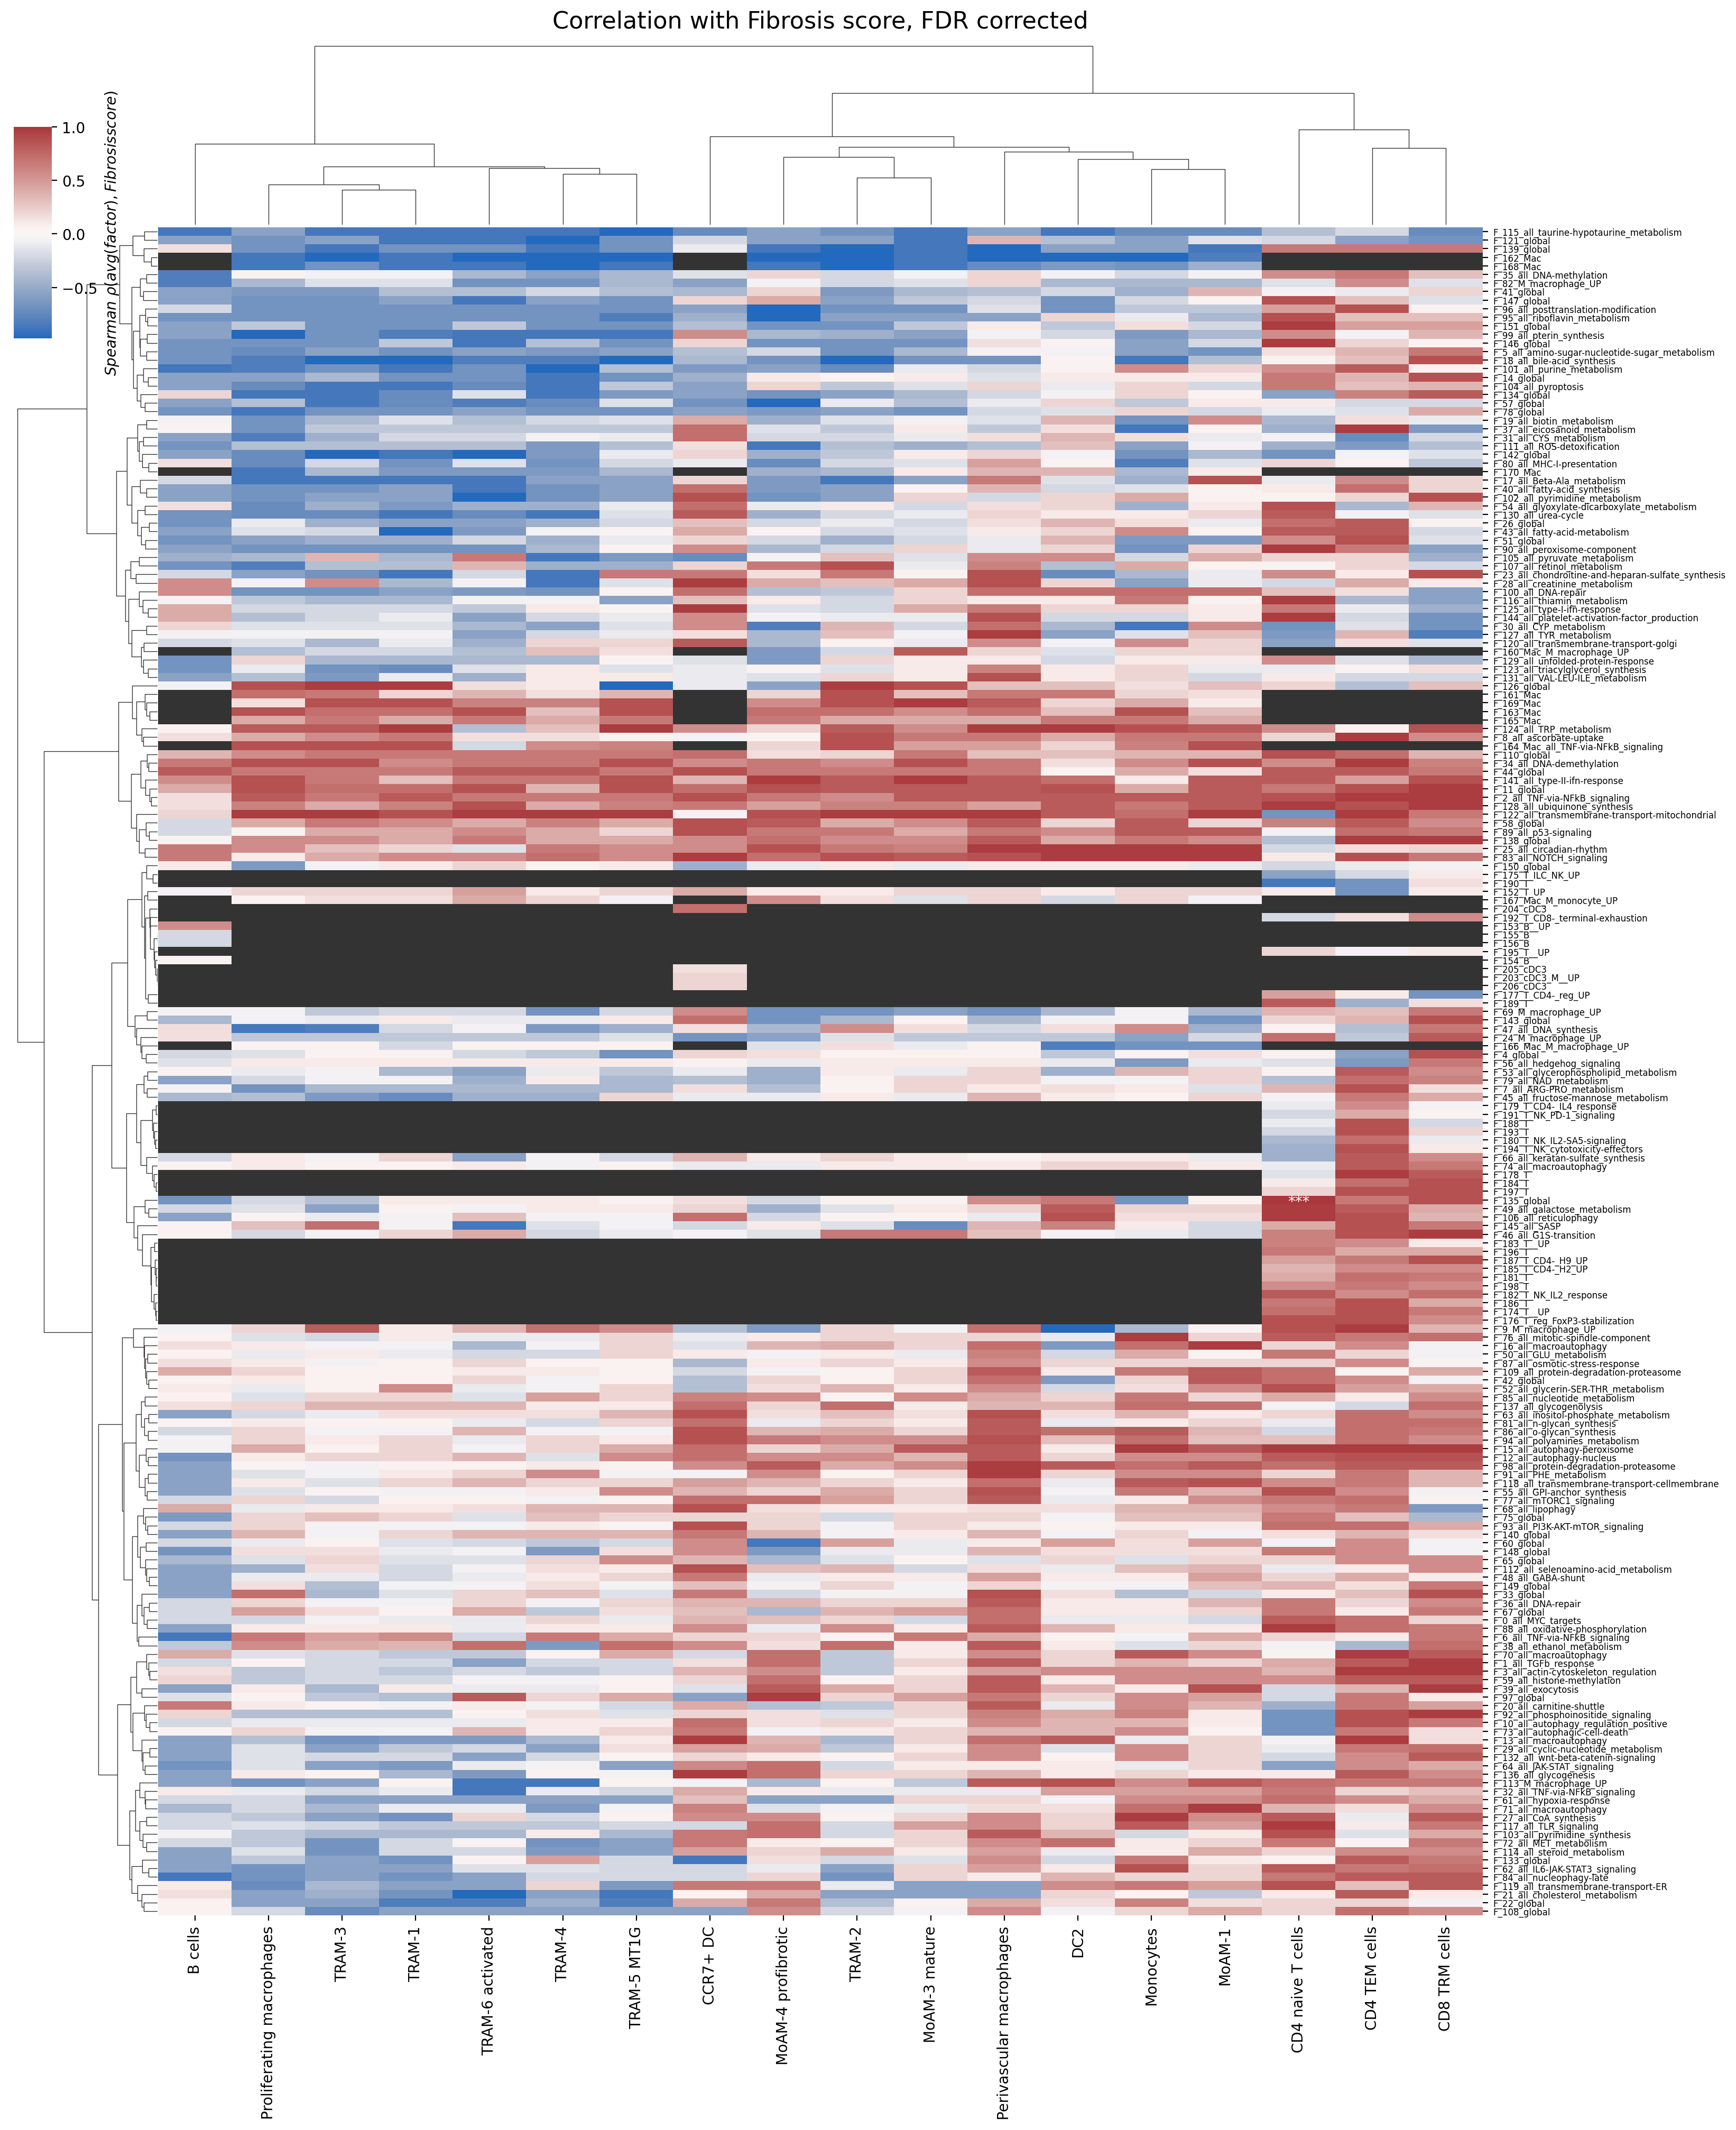

In [111]:
stats, pvals = spectra_clinical_corr(
    v3_mean_factors_w_clinical,
    factor_names,
    clinical_feature='k_score_fib'
)
cg = plot_spectra_clinical_corr(stats, pvals, 'Fibrosis score')
# cg.ax_col_dendrogram.figure.savefig('14b_factors_vs_fib_score.pdf', dpi=300)

In [120]:
stats.melt(
    var_name='cell_type',
    value_name='Spearman rho',
    ignore_index=False
).reset_index(names='factor').merge(
    pvals.melt(
        var_name='cell_type',
        value_name='padj',
        ignore_index=False
    ).reset_index(names='factor'),
    on=['factor', 'cell_type']
).sort_values('padj').head(10)

factor  \
135                                      F_135_global   
90                      F_90_all_peroxisome-component   
3031               F_76_all_mitotic-spindle-component   
2092  F_122_all_transmembrane-transport-mitochondrial   
1382            F_3_all_actin-cytoskeleton_regulation   
593                    F_2_all_TNF-via-NFkB_signaling   
594             F_3_all_actin-cytoskeleton_regulation   
3311                                        F_162_Mac   
1381                   F_2_all_TNF-via-NFkB_signaling   
2523                                        F_162_Mac   

                     cell_type Spearman rho      padj  
135          CD4 naive T cells          1.0       0.0  
90           CD4 naive T cells     0.974679  0.147288  
3031                 Monocytes     0.974679  0.147288  
2092          TRAM-6 activated     0.974679  0.147288  
1382             CD8 TRM cells     0.974679  0.147288  
593              CD4 TEM cells     0.974679  0.147288  
594              CD4 TEM cells     0.974679  0.147288  
3311  Perivascular macrophages    -0.974679  0.147288  
1381             CD8 TRM cells     0.974679  0.147288  
2523        MoAM-4 profibrotic    -0.974679  0.147288

In [119]:
v3_mean_factors_w_clinical.loc[
    v3_mean_factors_w_clinical.cell_type.eq('CD4 naive T cells')
][['External Sample ID', 'F_135_global', 'k_score_fib']]

External Sample ID  F_135_global  k_score_fib
223          SSc_SSc10      0.000076         13.0
247            SSc_C11      0.000066          NaN
270          SSc_SSc12      0.000068         12.0
294          SSc_SSc13      0.000013         11.0
319          SSc_SSc14      0.000000         10.0
342          SSc_SSc15      0.000000         10.0
363            Duke_C1      0.000038          NaN
394            Duke_C3      0.000553          NaN
418            Duke_C4      0.000023          NaN
437            Duke_C5      0.000006          NaN
462            Duke_C6      0.000002          NaN
476            Duke_C7      0.000103          NaN
496            Duke_C8      0.000186          NaN

<Axes: xlabel='F_135_global', ylabel='k_score_fib'>

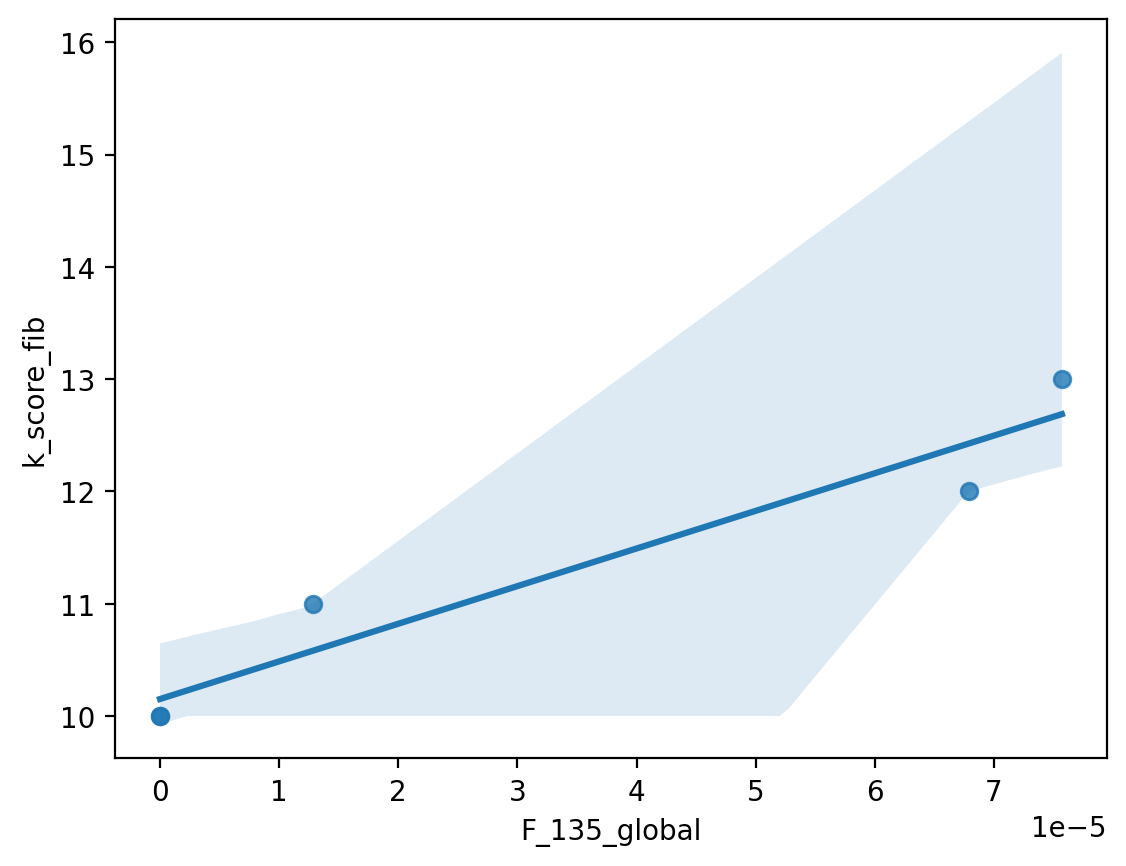

In [114]:
sns.regplot(
    data=v3_mean_factors_w_clinical.loc[v3_mean_factors_w_clinical.cell_type.eq(
        'CD4 naive T cells'
    )],
    x='F_135_global',
    y='k_score_fib'
)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


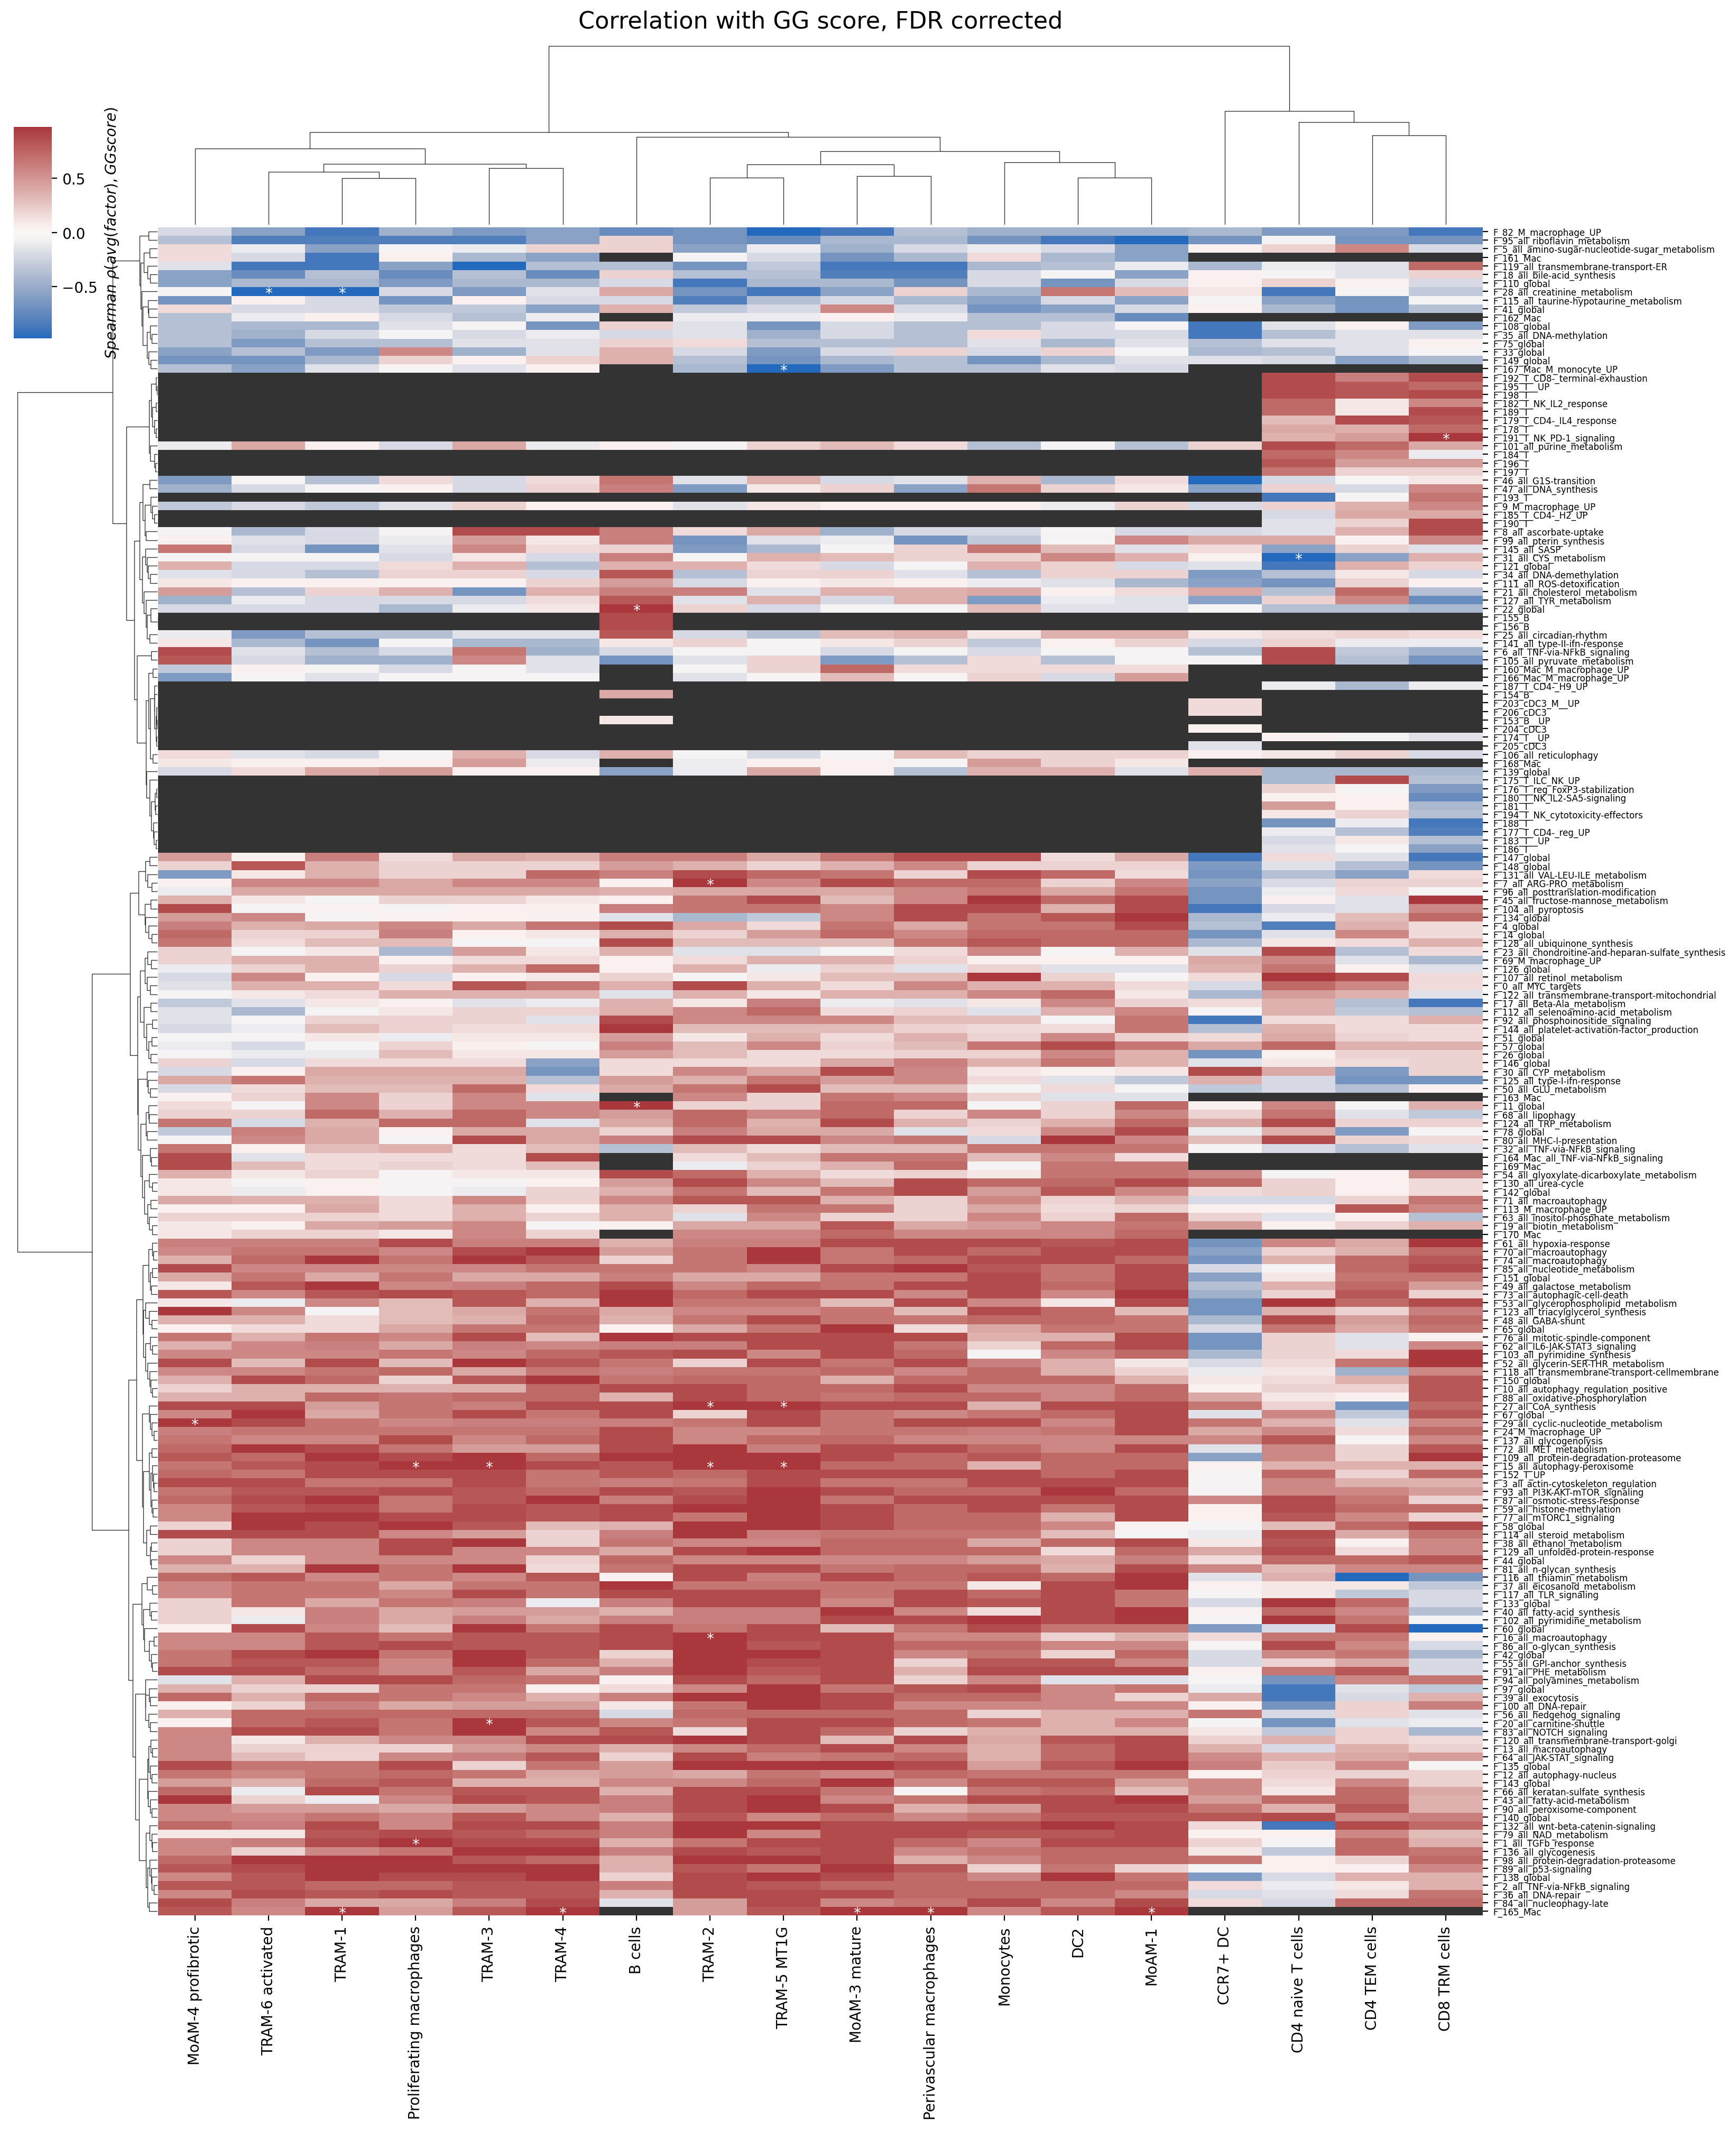

In [121]:
stats, pvals = spectra_clinical_corr(
    v3_mean_factors_w_clinical,
    factor_names,
    clinical_feature='k_score_gg'
)
cg = plot_spectra_clinical_corr(stats, pvals, 'GG score')
# cg.ax_col_dendrogram.figure.savefig('14b_factors_vs_fib_score.pdf', dpi=300)

In [122]:
stats.melt(
    var_name='cell_type',
    value_name='Spearman rho',
    ignore_index=False
).reset_index(names='factor').merge(
    pvals.melt(
        var_name='cell_type',
        value_name='padj',
        ignore_index=False
    ).reset_index(names='factor'),
    on=['factor', 'cell_type']
).sort_values('padj').head(10)

factor                 cell_type Spearman rho  \
2780                 F_22_global                   B cells     0.974679   
808   F_20_all_carnitine-shuttle                    TRAM-3     0.974679   
3314                   F_165_Mac  Perivascular macrophages     0.974679   
1937     F_167_Mac_M_monocyte_UP               TRAM-5 MT1G    -0.974679   
31       F_31_all_CYS_metabolism         CD4 naive T cells    -0.974679   
3511                   F_165_Mac                    MoAM-1     0.974679   
1738                   F_165_Mac                    TRAM-1     0.974679   
1344                   F_165_Mac             MoAM-3 mature     0.974679   
1147                   F_165_Mac                    TRAM-4     0.974679   
421       F_27_all_CoA_synthesis                    TRAM-2     0.974679   

          padj  
2780  0.013868  
808    0.01531  
3314  0.015575  
1937  0.015632  
31    0.015983  
3511  0.016043  
1738  0.016043  
1344  0.016508  
1147  0.016508  
421   0.017258

In [123]:
v3_mean_factors_w_clinical.loc[
    v3_mean_factors_w_clinical.cell_type.eq('B cells')
][['External Sample ID', 'F_22_global', 'k_score_gg']]

External Sample ID  F_22_global  k_score_gg
238          SSc_SSc10     0.000693        13.0
261            SSc_C11     0.000208         NaN
285          SSc_SSc12     0.000656        12.0
309          SSc_SSc13     0.000158         7.0
333          SSc_SSc14     0.000818        13.0
357          SSc_SSc15     0.000599         9.0
378            Duke_C1     0.000016         NaN
409            Duke_C3     0.000328         NaN
431            Duke_C4     0.000669         NaN
452            Duke_C5     0.001063         NaN
490            Duke_C7     0.000329         NaN
510            Duke_C8     0.001351         NaN

<Axes: xlabel='F_22_global', ylabel='k_score_gg'>

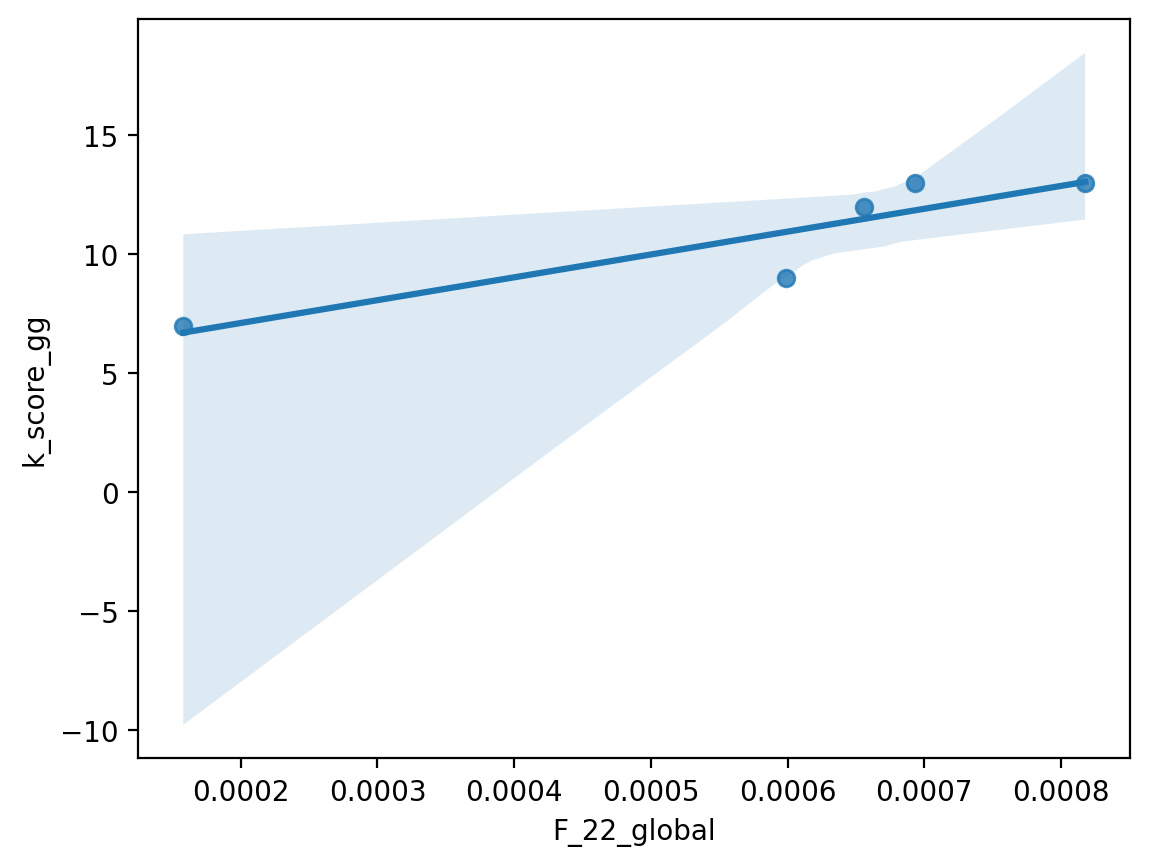

In [124]:
sns.regplot(
    data=v3_mean_factors_w_clinical.loc[v3_mean_factors_w_clinical.cell_type.eq(
        'B cells'
    )],
    x='F_22_global',
    y='k_score_gg'
)